# Analysis of EMBARC Flanker Data

In [2]:
import datetime, mmap,os,re, sys, decimal, hddm
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import pearsonr,shapiro,sem,ttest_ind
from patsy import dmatrix
import warnings 
warnings.filterwarnings('ignore')# I'm sick of all the red.
os.environ['R_HOME'] = '/Users/mlm2/anaconda/envs/pythonthreefive/lib/R' # couldn't find R in this environment for some reason
% matplotlib inline 
% load_ext rpy2.ipython
%R library(lsmeans)
%R library(afex)
%R library(ppcor)
%cd /Users/mlm2/Work/Expts/EMBARC/
import Flanker_proc

/Users/mlm2/anaconda/envs/pythonthreefive/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/mlm2/anaconda/envs/pythonthreefive/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


/Users/mlm2/Work/Expts/EMBARC


## Getting Data Together

In [137]:
uname = !whoami
uname = uname[0]
path2analysis = '/Users/' + uname + '/Work/Expts/EMBARC/' # also where git repo lives
today = datetime.datetime.today().strftime("%m_%d_%Y")

In [138]:
# getting in the clinical data that tells us which group the participant is in

clin_data = pd.read_csv(path2analysis + 'Data/groups.csv', encoding="latin-1")
clin_data = clin_data[['ProjectSpecificID', 'feasibility', 'shaps_total_dichotomous', 
                       'shaps_total_continuous', 'severity1','partic_age', 'partic_gender', 
                       'masq2_29', 'hamd_09','hamd_score_24','masq2_score_gd', 'masq2_score_ad',
                       'masq2_score_aa', 'neo2_score_ne']] 
clin_data = clin_data[pd.notnull(clin_data['feasibility'])] # only care where there is a val for feasibility
clin_data.head()

,ProjectSpecificID,feasibility,shaps_total_dichotomous,shaps_total_continuous,severity1,partic_age,partic_gender,masq2_29,hamd_09,hamd_score_24,masq2_score_gd,masq2_score_ad,masq2_score_aa,neo2_score_ne
1,TX0001,2.0,0.0,15.0,1.0,58.0,Female,5.0,0.0,29.0,26.0,48.0,11.0,15.0
3,TX0005,2.0,6.0,34.0,0.0,42.0,Female,4.0,0.0,21.0,30.0,45.0,13.0,30.0
5,TX0006,2.0,9.0,40.0,1.0,52.0,Female,5.0,0.0,28.0,29.0,48.0,17.0,18.0
7,TX0007,2.0,0.0,16.0,2.0,20.0,Female,1.0,0.0,0.0,15.0,14.0,10.0,2.0
9,TX0008,2.0,4.0,31.0,2.0,28.0,Male,3.0,0.0,2.0,13.0,34.0,10.0,19.0


In [139]:
clin_data.tail()

,ProjectSpecificID,feasibility,shaps_total_dichotomous,shaps_total_continuous,severity1,partic_age,partic_gender,masq2_29,hamd_09,hamd_score_24,masq2_score_gd,masq2_score_ad,masq2_score_aa,neo2_score_ne
707,CU0132,1.0,9.0,38.0,0.0,24.0,Female,5.0,0.0,26.0,18.0,47.0,17.0,31.0
709,CU0133,1.0,5.0,32.0,1.0,24.0,Female,4.0,0.0,28.0,39.0,46.0,20.0,46.0
711,CU0134,1.0,0.0,16.0,0.0,64.0,Female,5.0,0.0,10.0,37.0,39.0,27.0,40.0
713,CU0135,1.0,7.0,36.0,1.0,23.0,Female,5.0,0.0,32.0,34.0,43.0,22.0,33.0
715,CU0071,5.0,2.0,24.0,0.0,18.0,Female,5.0,0.0,24.0,23.0,44.0,21.0,40.0


In [105]:
## Preventive maintenance: clean up files with problems before starting the processing

## Rename file for Michigan subject 79, session 2 (subject and session were swapped)

!mv /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/Flanker_EMBARC_121312-2-0079.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/Flanker_EMBARC_121312-0079-2.txt

# Now correct the Subject and Session information for Michigan subject 79, session 2

!sed -e 's/Subject: 2/Subject: 79/' -e 's/Session: 0079/Session: 2/' \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/Flanker_EMBARC_121312-0079-2.txt > \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/temp.txt

!mv /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/temp.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/Flanker_EMBARC_121312-0079-2.txt

## Correct the subject number for Texas subject 61 (subject was entered as 695, session as 61)

!sed -e 's/Subject: 695/Subject: 0061/' -e 's/Session: 0061/Session: 1/' < \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_01172012-0061-1.txt > \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/temp.txt

!mv /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/temp.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_01172012-0061-1.txt

## Remove file labeled '038' for Texas; they are binary files, and there are already fine '0038' files

!rm /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_01172012-038-1.txt

## Correct the Subject and Session information for Texas subject 6, session 1 (they were reversed).
## File also ends with *1txt.txt, so overwrite it with a file ending *1.txt.

!sed -e 's/Subject: 1/Subject: 0006/' -e 's/Session: 0006/Session: 1/' < \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_04292011-0006-1.txt.txt > \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/temp.txt

!rm /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_04292011-0006-1.txt.txt

!mv /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/temp.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_04292011-0006-1.txt

## Correct the Subject information for Michigan subject 37, session 1. It is correct in the filename and in one
## line of the file, but is '0028' on another line, which will cause the processed data to be labeled as 0028.
## Since there are multiple other files for Michigan subject 37 and no others for Michigan subject 28, I am sticking
## with 37 as the correct subject number.

!sed -e 's/Subject: 0028/Subject: 0037/' < \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/Flanker_EMBARC_121312-0037-1.txt > \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/temp.txt

!mv /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/temp.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/Flanker_EMBARC_121312-0037-1.txt

## Replace files that were accidentally overwritten when traveling controls were processed. These are files for:
# MG subject 26, session 1
# NY subject 18, session 1
# NY subject 19, session 1
# TX subject 33, session 1

# Need to check in about traveling controls. 

!cp /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0018-1.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/New_York/EprimeOutFiles

!cp /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0019-1.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/New_York/EprimeOutFiles

!cp /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0026-1.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Massachusetts/EprimeOutFiles

!cp /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0033-1.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles

mv: /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/Flanker_EMBARC_121312-2-0079.txt: No such file or directory
rm: /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_01172012-038-1.txt: No such file or directory
/bin/sh: /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_04292011-0006-1.txt.txt: No such file or directory
rm: /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_04292011-0006-1.txt.txt: No such file or directory
mv: /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/temp.txt: No such file or directory
cp: /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0018-1.txt: No such file or directory
cp: /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0019-1.txt: No such file or directory
cp: /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0026-1.txt: No such file o

In [76]:
%cd /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/

# Regex definitions

site_d = re.compile('Site:\s([A-Za-z]+\s*[A-Za-z]+)')
sub_d = re.compile('Subject:\s(\d+)')
sess_d = re.compile('Session:\s([12])') # Excluding any session 3 data as that should always correspond to traveling ctrl

# Work on files from each site separately, as the filenames may overlap

sites = ['Massachusetts','Michigan','New_York','Texas']

for site in sites:
    # Grab files, omitting practice and 'output' files, as well as any labeled as session 3 (i.e., traveling ctrls)
    # Also omit CU0004 files labeled 'org', which were from an aborted, 'original' run that was re-run 
    file_list = !ls $site/EprimeOutFiles/*txt | grep 'Flanker_EMBARC_[0-9]' | grep -v '3.txt$' | grep -v 'org'
    
    for current_file in file_list:
               
        site = 'NA'
        sub = np.nan
        sess = np.nan
        
        with open(current_file,'r', encoding="latin-1") as f:
        
            for line in f:
                
                site_m = site_d.search(line)
                sub_m = sub_d.search(line)
                sess_m = sess_d.search(line)
                
                # Site
                if site_m:
                    site = site_m.group(1)
                    
                    if site == 'Massachusetts':
                        site = 'MG'
                    
                    elif site == 'Michigan':
                        site = 'UM'
                    
                    elif site == 'New York':
                        site = 'CU'
                    
                    elif site == 'Texas':
                        site = 'TX'
                             
                # Subject
                if sub_m:
                    subject = sub_m.group(1)
                    subject = subject.zfill(4) # Subject should always be width=4
        
                # Session
                if sess_m:
                    session = sess_m.group(1)
                    
        fname = site + '_' + subject + '_' + str(session) + '.txt'           
        !cp $current_file /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Raw/$fname 

/Users/mlm2/Work/Expts/EMBARC/Data/Flanker


In [78]:
## Push raw data through processing stream in order to get (a) CSV files that could be used
## for DDM analysis and (b) summary files with interference, gratton, and rab/lam effects

%cd /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Raw/

# Iterate over files, extracting site, subject, and session information from filenames
# Place single-subject trial-level and summary into 'ddm_pieces' and 'sum_pieces', respectively
# Write out single-subject trial-level CSV and group summary CSV for safe-keeping

ddm_pieces = []
sum_pieces = []

file_list = !ls *txt

for current_file in file_list:
    
    site = current_file.split('_')[0]
    sub = current_file.split('_')[1]
    sess = current_file.split('_')[2]
    sess = sess.split('.')[0]
    # print(sub)
    
    fname = site + '_' + sub + '_' + sess + '.csv'
                        
    # Output clean CSV for the DDM, also append it to 'ddm_pieces'
    clean_df = Flanker_proc.clean(current_file)
    clean_df['site'] = site
    clean_df = clean_df[['site','subject','session','block','trial','stimulus','response','accuracy','rt','feedback',
                         'ln_rt','outlier','rab_lam','gratton']]
    try:
        clean_df.to_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/' + fname, index=False)
    except:
        print ('didnt work')
    ddm_pieces.append(clean_df)
    
    # Generate the summary and place it in 'sum_pieces'
    
    sum_frame = Flanker_proc.summarize(clean_df)
    sum_frame['site'] = site
    sum_frame['subject'] = sub
    sum_frame['session'] = sess
    
    sum_pieces.append(sum_frame)
 
# Concatenate pieces into dfs

trial_summary = pd.concat(ddm_pieces)
trial_summary.sort(['site','subject','session'],inplace=True)
trial_summary

flanker_summary = pd.concat(sum_pieces)   
flanker_summary.sort(columns=['site','subject','session'],inplace=True)

# For the Flanker Summary, create and add ProjectSpecificID for merge with PA clin file.

new_subject = []

flanker_summary['subject'] = flanker_summary['subject'].astype(str)

for i, row_i in flanker_summary.iterrows():
    new_subject.append(row_i['subject'].zfill(4))

flanker_summary['subject'] = new_subject
flanker_summary['ProjectSpecificID'] = flanker_summary['site'] + flanker_summary['subject']

# Put the summary columns in a nicer order

# flanker_summary = flanker_summary[['ProjectSpecificID', 'site', 'subject', 'session','num_outs', 'num_noresp', 
#                                    'num_con_trls', 'con_acc', 'con_corr_rt', 'num_inc_trls', 'inc_acc', 'inc_corr_rt', 
#                                    'num_post_inc_err', 'flanker_qc', 'gratton_qc', 'rab_lam_qc', 'flanker_acc', 
#                                    'flanker_rt', 'gratton_acc', 'gratton_rt', 'rab_lam_acc', 'rab_lam_rt']]

flanker_summary = flanker_summary[['ProjectSpecificID', 'site', 'subject', 'session', 'num_outs', 'num_noresp', 
                                   'num_con_trls', 'con_acc', 'con_corr_rt', 'num_inc_trls', 'inc_acc', 
                                   'inc_corr_rt', 'con_inc_acc', 'con_inc_rt', 'inc_inc_acc', 'inc_inc_rt', 
                                   'post_err_acc', 'post_err_rt', 'post_corr_acc', 'post_corr_rt', 
                                   'num_post_inc_err', 'flanker_qc', 'gratton_qc', 'rab_lam_qc', 'flanker_acc', 
                                   'flanker_rt', 'gratton_acc', 'gratton_rt', 'rab_lam_acc', 'rab_lam_rt']]

# Write trial-level data and group summary to CSV

trial_summary.to_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_DDM_'
                     + datetime.datetime.now().strftime('%b-%d-%I%M%p-%G') + '.csv',index=False)

flanker_summary.to_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_Summary_' 
                       + datetime.datetime.now().strftime('%b-%d-%I%M%p-%G') + '.csv',index=False)


/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Raw


In [79]:
len(flanker_summary)

719

In [80]:
flanker_summary.head()

,ProjectSpecificID,site,subject,session,num_outs,num_noresp,num_con_trls,con_acc,con_corr_rt,num_inc_trls,...,num_post_inc_err,flanker_qc,gratton_qc,rab_lam_qc,flanker_acc,flanker_rt,gratton_acc,gratton_rt,rab_lam_acc,rab_lam_rt
0,CU0001,CU,0001,1,4,4,224,0.995536,407.587444,118,...,5,1,1,0,0.046383,44.707199,-0.009868,10.944079,0.018018,13.025225
0,CU0001,CU,0001,2,3,0,230,0.991304,376.175439,117,...,2,1,1,0,0.008398,36.581083,-0.048514,11.536082,0.008772,-12.403509
0,CU0002,CU,0002,1,3,3,228,0.986842,417.062222,116,...,8,1,1,1,0.055808,93.900741,-0.004758,-40.540048,0.028302,79.365566
0,CU0002,CU,0002,2,2,0,229,0.995633,385.885965,119,...,13,1,1,1,0.104877,85.661205,0.120000,-19.885000,0.000000,7.757509
0,CU0003,CU,0003,1,2,23,214,0.953271,326.240196,111,...,41,1,1,1,0.331649,74.817775,0.027299,-11.556034,0.020579,6.974085


In [81]:
flanker_summary.tail()

,ProjectSpecificID,site,subject,session,num_outs,num_noresp,num_con_trls,con_acc,con_corr_rt,num_inc_trls,...,num_post_inc_err,flanker_qc,gratton_qc,rab_lam_qc,flanker_acc,flanker_rt,gratton_acc,gratton_rt,rab_lam_acc,rab_lam_rt
0,UM0119,UM,0119,2,7,0,227,0.995595,339.743363,116,...,6,1,1,1,0.047319,74.020274,0.063830,-8.336879,0.000000,28.870370
0,UM0120,UM,0120,1,2,0,228,1.000000,280.864035,120,...,22,1,1,1,0.191667,44.074109,0.000619,-3.655322,-0.014527,-3.774133
0,UM0120,UM,0120,2,0,0,230,0.995652,265.074236,120,...,25,1,1,1,0.203986,44.715238,0.017822,9.993399,0.031579,4.023158
0,UM0121,UM,0121,1,3,1,227,1.000000,427.563877,119,...,12,1,1,1,0.100840,116.333320,0.112245,-32.688383,0.000000,-11.724359
0,UM0121,UM,0121,2,6,0,227,0.995595,419.867257,117,...,6,1,1,1,0.055424,84.514562,-0.007277,6.311704,0.018349,-3.174312


In [82]:
len(trial_summary)

251528

In [83]:
trial_summary.head()

,site,subject,session,block,trial,stimulus,response,accuracy,rt,feedback,ln_rt,outlier,rab_lam,gratton
0,CU,1,1,1,1,INC,right,1.0,697.0,TOO_SLOW,6.546785,0,0,0
1,CU,1,1,1,2,CON,left,1.0,402.0,Blank,5.996452,0,2,0
2,CU,1,1,1,3,INC,left,1.0,390.0,Blank,5.966147,0,0,1
3,CU,1,1,1,4,CON,right,1.0,342.0,Blank,5.834811,0,2,0
4,CU,1,1,1,5,INC,left,1.0,406.0,Blank,6.006353,0,0,1


In [84]:
trial_summary.tail()

,site,subject,session,block,trial,stimulus,response,accuracy,rt,feedback,ln_rt,outlier,rab_lam,gratton
345,UM,121,2,5,66,INC,left,1.0,529.0,Blank,6.270988,0,0,1
346,UM,121,2,5,67,INC,right,1.0,547.0,Blank,6.304449,0,2,2
347,UM,121,2,5,68,CON,right,1.0,429.0,Blank,6.061457,0,2,0
348,UM,121,2,5,69,CON,right,1.0,355.0,Blank,5.872118,0,0,0
349,UM,121,2,5,70,CON,left,1.0,453.0,Blank,6.115892,0,0,0


In [99]:
flk_sum = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_Summary_Mar-03-1012AM-2017.csv')
flk_ddm = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_DDM_Mar-03-1012AM-2017.csv')

In [100]:
clin_data.ProjectSpecificID.unique()

array(['TX0001', 'TX0005', 'TX0006', 'TX0007', 'TX0008', 'TX0009',
       'TX0010', 'TX0011', 'TX0012', 'TX0014', 'TX0016', 'TX0019',
       'TX0020', 'TX0022', 'TX0027', 'TX0029', 'CU0125', 'CU0126',
       'CU0127', 'CU0128', 'CU0129', 'UM0103', 'UM0111', 'UM0110',
       'UM0113', 'UM0114', 'UM0115', 'UM0116', 'UM0118', 'UM0117',
       'UM0119', 'UM0120', 'UM0121', 'UM0006', 'UM0023', 'UM0021',
       'UM0024', 'UM0012', 'UM0032', 'UM0035', 'UM0005', 'UM0014',
       'UM0031', 'UM0008', 'UM0029', 'UM0002', 'UM0003', 'UM0004',
       'UM0011', 'UM0013', 'UM0015', 'UM0016', 'UM0017', 'UM0027',
       'UM0025', 'UM0040', 'UM0034', 'UM0033', 'UM0036', 'UM0037',
       'UM0038', 'UM0042', 'UM0046', 'UM0047', 'UM0048', 'UM0049',
       'UM0050', 'UM0051', 'UM0052', 'UM0056', 'UM0058', 'UM0060',
       'UM0065', 'UM0066', 'UM0073', 'UM0074', 'UM0077', 'UM0078',
       'UM0079', 'UM0080', 'UM0082', 'UM0083', 'UM0085', 'UM0089',
       'UM0088', 'UM0091', 'UM0090', 'UM0092', 'UM0094', 'UM00

In [107]:
# Merge the session 1 flanker summary with the clinical data and write out
s1 = flk_sum[(flk_sum['session'] == 1)]
flk_clin_s1 = pd.merge(s1,clin_data,on='ProjectSpecificID')
flk_clin_s1.to_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_Clin_s1_'
                     + datetime.datetime.now().strftime('%b-%d-%I%M%p-%G') + '.csv',index=False)

In [108]:
# Add group data to the flk_ddm dataframe by merging it with the clinical data, 
# then select session 1 data for controls and MDD before sending to TW.

# Add ProjectSpecificID to flk_ddm
new_subs = []
flk_ddm['subject'] = flk_ddm['subject'].astype(int)
flk_ddm['subject'] = flk_ddm['subject'].astype(str)

for i, row_i in flk_ddm.iterrows():
    sub = row_i['subject'].zfill(4)
    new_subs.append(sub)

flk_ddm['subject'] = new_subs
flk_ddm['ProjectSpecificID'] = flk_ddm['site']+ flk_ddm['subject']

# Match on ProjectSpecificID with clin_data
flk_ddm_clin = pd.merge(flk_ddm,clin_data,on='ProjectSpecificID')

# Select only control (feasibility = 4.0) and MDD (feasibility = 3.0) subjects
flk_ddm_clin = flk_ddm_clin[(flk_ddm_clin.feasibility != 2.0)]
flk_ddm_clin.rename(columns={'site_x': 'site', 'subject_x': 'subject', 'session_x': 'session'}, inplace=True)

# Group: 0 = controls, 1 = MDD
flk_ddm_clin['group'] = flk_ddm_clin['feasibility']
flk_ddm_clin['group'].replace(to_replace = 1.0,value = 'MDD', inplace = True) #MDD = 1
flk_ddm_clin['group'].replace(to_replace = 3.0,value = 'MDD', inplace = True) #MDD = 1
flk_ddm_clin['group'].replace(to_replace = 5.0,value = 'MDD', inplace = True) #MDD = 1
flk_ddm_clin['group'].replace(to_replace = 4.0,value = 'CTL', inplace = True) #Ctrl = 0

# Now select session 1 data to send to TW
flk_ddm_clin_s1 = flk_ddm_clin[flk_ddm_clin['session'] == 1]

# Now just write out ProjectSpecific ID, group, and all the flanker columns. I am not writing out everything b/c with
# the clinical data repeated on every single line, the file that would be written out would be huge (~200MB).

flk_ddm_clin_s1 = flk_ddm_clin_s1[['ProjectSpecificID','site','subject','session','group','block','trial','stimulus',
                             'response','accuracy','rt','feedback','ln_rt','outlier','rab_lam','gratton']]

# Use lines below to confirm number of subjects in each group. As of June 17, 2014, there are 40 ctrls and 98 mdd.
bygroup = flk_ddm_clin_s1.groupby('group')
print(bygroup['ProjectSpecificID'].nunique())

# Write out the file for TW
flk_ddm_clin_s1.to_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_DDM_Clin_s1_'
                     + datetime.datetime.now().strftime('%b-%d-%I%M%p-%G') + '.csv',index=False)

group
CTL     38
MDD    292
Name: ProjectSpecificID, dtype: int64


In [111]:
# Checking that the subjects look okay
checking_clin = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_DDM_Clin_s1_Mar-03-1058AM-2017.csv')
print (checking_clin.ProjectSpecificID.count())
checking_clin.drop_duplicates('ProjectSpecificID')
print(checking_clin.ProjectSpecificID.count()) # no duplicates


115500
115500


## Analysis

In [141]:
# Working with 'flk_clin_s1' as the bash-like summary file merged with the latest PA spreadsheet
# First select the controls (feasibility = 4) and the mdds (feasibility = 3), add 'group' col, and re-label groups
flk_clin_s1 = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_Clin_s1_Mar-03-1057AM-2017.csv')
flk_clin_s1 = flk_clin_s1[(flk_clin_s1.feasibility != 2.0)]
flk_clin_s1['group'] = flk_clin_s1['feasibility']
flk_clin_s1['group'].replace(to_replace = 1.0,value = 'MDD', inplace = True) #MDD = 1
flk_clin_s1['group'].replace(to_replace = 3.0,value = 'MDD', inplace = True) #MDD = 1
flk_clin_s1['group'].replace(to_replace = 5.0,value = 'MDD', inplace = True) #MDD = 1
flk_clin_s1['group'].replace(to_replace = 4.0,value = 'CTL', inplace = True) #Ctrl = 0

In [142]:
flk_clin_s1.tail()

,ProjectSpecificID,site,subject,session,num_outs,num_noresp,num_con_trls,con_acc,con_corr_rt,num_inc_trls,...,rab_lam_rt,feasibility,shaps_total_dichotomous,shaps_total_continuous,severity1,partic_age,partic_gender,masq2_29,hamd_09,group
347,UM0117,UM,117,1,2,0,228,0.991228,334.557522,120,...,34.410487,1.0,0.0,28.0,0.0,45.0,Male,3.0,0.0,MDD
348,UM0118,UM,118,1,2,1,228,0.986842,340.906667,119,...,-1.619048,1.0,3.0,32.0,0.0,19.0,Female,5.0,2.0,MDD
349,UM0119,UM,119,1,9,1,224,1.000000,336.991071,116,...,-7.355346,1.0,2.0,29.0,0.0,32.0,Male,5.0,0.0,MDD
350,UM0120,UM,120,1,2,0,228,1.000000,280.864035,120,...,-3.774133,1.0,0.0,26.0,0.0,20.0,Female,4.0,0.0,MDD
351,UM0121,UM,121,1,3,1,227,1.000000,427.563877,119,...,-11.724359,1.0,8.0,36.0,0.0,56.0,Female,5.0,0.0,MDD


In [143]:
flk_clin_s1.groupby(['site', 'group'])['ProjectSpecificID'].nunique()

site  group
CU    CTL       9
      MDD      86
MG    CTL      10
      MDD      52
TX    CTL       9
      MDD      97
UM    CTL      10
      MDD      57
Name: ProjectSpecificID, dtype: int64

In [144]:
flk_clin_s1.groupby(['group'])['ProjectSpecificID'].nunique()

group
CTL     38
MDD    292
Name: ProjectSpecificID, dtype: int64

In [145]:
# Compare these with the PRT people. Need to look into each one and see why they weren't included. See notes below.
# Is there a master list of people? Comparing to the included PRT people is helpful but we could miss some things. 
# I guess could just take the group data and compare to each unique subject id?

df_christian = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/christian_included.txt', header = None)    
christian_list = df_christian[0].astype(str)

# are we missing anything?
for subject in christian_list:
    if subject in flk_clin_s1.ProjectSpecificID.unique():
        pass
    else:
        print('Missing from ours: '+ subject)

# do we have anything extra?
for subject in flk_clin_s1.ProjectSpecificID:
    if subject in christian_list.unique():
        pass
    else:
        print('Not included in PRT: ' + subject)

Missing from ours: TX0165
Missing from ours: CU0018
Missing from ours: TX0033
Not included in PRT: CU0019
Not included in PRT: CU0021
Not included in PRT: CU0060
Not included in PRT: CU0062
Not included in PRT: CU0064
Not included in PRT: CU0113
Not included in PRT: CU0125
Not included in PRT: CU0126
Not included in PRT: CU0133
Not included in PRT: MG0008
Not included in PRT: MG0021
Not included in PRT: MG0026
Not included in PRT: MG0116
Not included in PRT: MG0182
Not included in PRT: MG0185
Not included in PRT: MG0238
Not included in PRT: MG0242
Not included in PRT: MG0246
Not included in PRT: MG0257
Not included in PRT: TX0011
Not included in PRT: TX0016
Not included in PRT: TX0020
Not included in PRT: TX0050
Not included in PRT: TX0060
Not included in PRT: TX0066
Not included in PRT: TX0097
Not included in PRT: TX0119
Not included in PRT: TX0127
Not included in PRT: TX0142
Not included in PRT: TX0147
Not included in PRT: TX0153
Not included in PRT: TX0178
Not included in PRT: TX018

**TX0165** has an eprime out file, but it doesn't have anything in it and the file is called '...0165-1.text-CORRUPT', so I think it's reasonable that we don't include them.  
  
**TX0033** not sure why they aren't here, they are mentioned earlier in the code as being overwritten accidentally, but I see both their eprime file and their summary file. It looks like they only have session 2 in Flk_Summary. Okay, so the reason that it's being overwritten when making the raw file is that 'Site' was entered (likely incorrectly) as 'New York,' in the eprime out file, so I think that the New York 0033 is writing over it, though I don't know where this is happening. Is this a traveling control problem and the site part actually is accurate?    
  
**CU0018** we have both files from them, so I'm not sure why they're not included. Will need to look into more. It looks like they only have session 2 in Flk_Summary. So this seems to be the same problem as TX0033, the site in the eprime out file was entered as MA. Not sure if it's kosher to fix it directly in the text file. Is this a traveling control problem and the site part actually is accurate?  



In [146]:
# Now select only those subjects who pass the Flanker QC check at session 1
flk_use = flk_clin_s1[flk_clin_s1.flanker_qc == 1]
bygroup = flk_use.groupby('group')
bygroup.ProjectSpecificID.nunique()

group
CTL     35
MDD    266
Name: ProjectSpecificID, dtype: int64

In [147]:
# Which subjects get excluded based on flanker QC fails?
flk_qc_fails = []

flk_ids = flk_clin_s1.ProjectSpecificID.unique()
flk_ids = flk_ids.tolist()

flk_use_ids = flk_use.ProjectSpecificID.unique()
flk_use_ids = flk_use_ids.tolist()

for sub in flk_ids:
    if sub not in flk_use_ids:
        print (sub + ' was excluded based on flanker QC fail')
        flk_qc_fails.append(sub)

CU0017 was excluded based on flanker QC fail
CU0025 was excluded based on flanker QC fail
CU0060 was excluded based on flanker QC fail
CU0062 was excluded based on flanker QC fail
CU0110 was excluded based on flanker QC fail
CU0116 was excluded based on flanker QC fail
MG0007 was excluded based on flanker QC fail
MG0116 was excluded based on flanker QC fail
MG0125 was excluded based on flanker QC fail
MG0182 was excluded based on flanker QC fail
MG0206 was excluded based on flanker QC fail
MG0209 was excluded based on flanker QC fail
MG0238 was excluded based on flanker QC fail
MG0251 was excluded based on flanker QC fail
TX0037 was excluded based on flanker QC fail
TX0050 was excluded based on flanker QC fail
TX0062 was excluded based on flanker QC fail
TX0068 was excluded based on flanker QC fail
TX0101 was excluded based on flanker QC fail
TX0124 was excluded based on flanker QC fail
TX0139 was excluded based on flanker QC fail
TX0147 was excluded based on flanker QC fail
TX0188 was

## Descriptive data and group comparisons on demographics, Flanker interference, Gratton, and Rabbit/Laming effects

In [148]:
%Rpush flk_use

**Age**  
No group difference

In [149]:
bygroup['partic_age'].describe()

group       
CTL    count     35.000000
       mean      36.400000
       std       14.637181
       min       18.000000
       25%       25.000000
       50%       31.000000
       75%       52.000000
       max       62.000000
MDD    count    266.000000
       mean      37.056391
       std       13.011483
       min       18.000000
       25%       26.000000
       50%       34.000000
       75%       47.000000
       max       65.000000
Name: partic_age, dtype: float64

In [150]:
%R print(t.test(partic_age ~ group,flk_use))


	Welch Two Sample t-test

data:  partic_age by group
t = -0.2525, df = 41.38, p-value = 0.8019
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -5.904880  4.592098
sample estimates:
mean in group CTL mean in group MDD 
         36.40000          37.05639 



**Gender**  
No group difference

In [151]:
print (bygroup['partic_gender'].value_counts())

group  partic_gender
CTL    Female            21
       Male              14
MDD    Female           174
       Male              92
Name: partic_gender, dtype: int64


In [152]:
obs = np.array([[21,14],[174,92]])
chi2, p, dof, expected = sp.stats.chi2_contingency(obs,correction=False)
print ("Chi-square on Gender: chi-square = " + "{:.2f}".format(chi2) + "; df = " + "{:.2f}".format(dof) + \
"; p = " + "{:.2f}".format(p))

Chi-square on Gender: chi-square = 0.40; df = 1.00; p = 0.53


### Flanker interference 

In [153]:
# No group difference in accuracy
bygroup['flanker_acc'].describe()

group       
CTL    count     35.000000
       mean       0.215206
       std        0.124715
       min        0.033898
       25%        0.109499
       50%        0.191667
       75%        0.291150
       max        0.491667
MDD    count    266.000000
       mean       0.192571
       std        0.112452
       min       -0.004425
       25%        0.113902
       50%        0.181920
       75%        0.249781
       max        0.473576
Name: flanker_acc, dtype: float64

In [154]:
# Accuracy on CON trials is very similar across groups
bygroup['con_acc'].describe()

group       
CTL    count     35.000000
       mean       0.987746
       std        0.012436
       min        0.964126
       25%        0.977974
       50%        0.991228
       75%        1.000000
       max        1.000000
MDD    count    266.000000
       mean       0.984663
       std        0.026325
       min        0.715596
       25%        0.981879
       50%        0.991266
       75%        1.000000
       max        1.000000
Name: con_acc, dtype: float64

In [155]:
# INC accuracy is slightly higher in MDDs
bygroup['inc_acc'].describe()

group       
CTL    count     35.000000
       mean       0.772539
       std        0.127243
       min        0.508333
       25%        0.702836
       50%        0.788136
       75%        0.885122
       max        0.966102
MDD    count    266.000000
       mean       0.792092
       std        0.116430
       min        0.504202
       25%        0.726523
       50%        0.805904
       75%        0.872881
       max        1.000000
Name: inc_acc, dtype: float64

In [156]:
# Looking for group difference in RT
bygroup['flanker_rt'].describe()

group       
CTL    count     35.000000
       mean      86.775766
       std       21.246150
       min       55.906337
       25%       72.455585
       50%       84.915119
       75%       95.206870
       max      159.605979
MDD    count    266.000000
       mean      92.410056
       std       21.752345
       min       37.341151
       25%       79.214792
       50%       93.169638
       75%      105.274141
       max      169.608911
Name: flanker_rt, dtype: float64

In [157]:
# Controls are faster than MDDs with respect to correct CON RT
bygroup['con_corr_rt'].describe()

group       
CTL    count     35.000000
       mean     359.971081
       std       43.773767
       min      294.875556
       25%      328.433881
       50%      356.632743
       75%      388.156132
       max      499.517544
MDD    count    266.000000
       mean     377.597464
       std       52.555303
       min      271.885463
       25%      340.290000
       50%      368.076038
       75%      406.799559
       max      574.513761
Name: con_corr_rt, dtype: float64

In [158]:
# Controls are also faster than depressed with respect to INC correct RT
bygroup['inc_corr_rt'].describe()

group       
CTL    count     35.000000
       mean     446.746847
       std       46.097367
       min      378.672131
       25%      410.016758
       50%      443.597938
       75%      464.131616
       max      574.802326
MDD    count    266.000000
       mean     470.007520
       std       57.848143
       min      324.938144
       25%      429.519792
       50%      462.475121
       75%      504.617527
       max      712.000000
Name: inc_corr_rt, dtype: float64

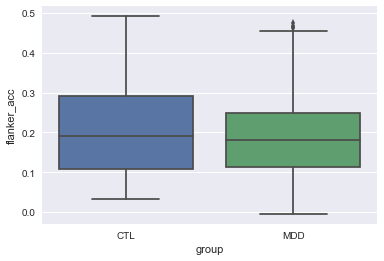

In [159]:
# boxplot showing interference effect on accuracy by group
sns.boxplot(flk_use['flanker_acc'],groupby=flk_use['group'],names=['Control','MDD'])

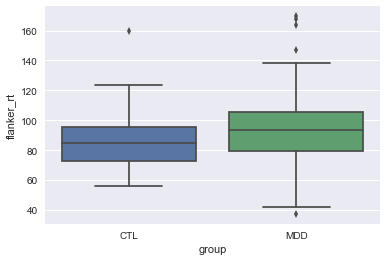

In [160]:
# boxplot showing interference effect on RT by group
sns.boxplot(flk_use['flanker_rt'],groupby=flk_use['group'],names=['Control','MDD'])

In [161]:
# How about number of outliers per group? Slightly higher in MDD, but not much of a difference.
bygroup.num_outs.describe()

group       
CTL    count     35.000000
       mean       3.342857
       std        1.570741
       min        0.000000
       25%        2.000000
       50%        3.000000
       75%        4.000000
       max        7.000000
MDD    count    266.000000
       mean       3.545113
       std        2.221642
       min        0.000000
       25%        2.000000
       50%        3.000000
       75%        5.000000
       max       18.000000
Name: num_outs, dtype: float64

In [162]:
# For interference effect on accuracy, confirm that effect is greater than zero in each group, and then check group diff.
%R flk_use.ctrl <- subset(flk_use,group == 'CTL')
%R flk_use.mdd <- subset(flk_use,group == 'MDD')
%R print(t.test(flk_use.ctrl$flanker_acc,mu=0)) # Controls, p < 0.001
%R print(t.test(flk_use.mdd$flanker_acc,mu=0)) # MDD, p < 0.001
%R print(t.test(flanker_acc ~ group,flk_use)) # ****The trend found with the first half of the data is gone here*****


	One Sample t-test

data:  flk_use.ctrl$flanker_acc
t = 10.209, df = 34, p-value = 6.855e-12
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.1723654 0.2580473
sample estimates:
mean of x 
0.2152064 




	One Sample t-test

data:  flk_use.mdd$flanker_acc
t = 27.93, df = 265, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.1789954 0.2061468
sample estimates:
mean of x 
0.1925711 




	Welch Two Sample t-test

data:  flanker_acc by group
t = 1.0205, df = 41.602, p-value = 0.3134
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.02213750  0.06740807
sample estimates:
mean in group CTL mean in group MDD 
        0.2152064         0.1925711 



In [163]:
# For interference effect on RT, confirm that effect is greater than zero in each group, and then check group diff.
%R print(t.test(flk_use.ctrl$flanker_rt,mu=0)) # Controls, p < 0.001
%R print(t.test(flk_use.mdd$flanker_rt,mu=0)) # MDD, p < 0.001
%R print(t.test(flanker_rt ~ group,flk_use)) #  p = 0.149


	One Sample t-test

data:  flk_use.ctrl$flanker_rt
t = 24.163, df = 34, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 79.47746 94.07407
sample estimates:
mean of x 
 86.77577 




	One Sample t-test

data:  flk_use.mdd$flanker_rt
t = 69.287, df = 265, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 89.78402 95.03610
sample estimates:
mean of x 
 92.41006 




	Welch Two Sample t-test

data:  flanker_rt by group
t = -1.4707, df = 43.918, p-value = 0.1485
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -13.355402   2.086821
sample estimates:
mean in group CTL mean in group MDD 
         86.77577          92.41006 



In [164]:
# Gratton effect on accuracy--looks the same
bygroup.gratton_acc.describe()

group       
CTL    count     35.000000
       mean       0.069278
       std        0.098367
       min       -0.111111
       25%        0.003882
       50%        0.054545
       75%        0.136324
       max        0.274561
MDD    count    266.000000
       mean       0.069786
       std        0.114277
       min       -0.328462
       25%        0.001052
       50%        0.069954
       75%        0.138947
       max        0.435354
Name: gratton_acc, dtype: float64

In [165]:
# Gratton effect on RT--negative is better, and it looks more negative in controls
bygroup.gratton_rt.describe()

group       
CTL    count     35.000000
       mean      -8.003311
       std       21.848722
       min      -65.165789
       25%      -18.141826
       50%       -4.196285
       75%        5.739958
       max       22.560606
MDD    count    266.000000
       mean      -2.910442
       std       21.578954
       min      -60.111111
       25%      -18.144889
       50%       -2.238752
       75%       10.784784
       max       73.210870
Name: gratton_rt, dtype: float64

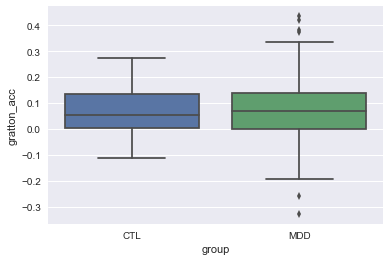

In [166]:
# Gratton accuracy effect
sns.boxplot(flk_use.gratton_acc,groupby=flk_use.group,names=['Control','MDD'])

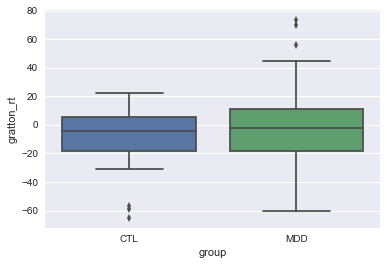

In [167]:
# Gratton RT effect
sns.boxplot(flk_use.gratton_rt,groupby=flk_use.group,names=['Control','MDD'])

In [168]:
# For Gratton effect on accuracy, see if effect is greater than zero in each group, and then check group diff.
%R print(t.test(flk_use.ctrl$gratton_acc,mu=0)) # Controls, p < .001
%R print(t.test(flk_use.mdd$gratton_acc,mu=0)) # MDD, p < .001
%R print(t.test(gratton_acc ~ group,flk_use)) # No group difference, p = 0.98


	One Sample t-test

data:  flk_use.ctrl$gratton_acc
t = 4.1666, df = 34, p-value = 0.0002004
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.03548761 0.10306813
sample estimates:
 mean of x 
0.06927787 




	One Sample t-test

data:  flk_use.mdd$gratton_acc
t = 9.9598, df = 265, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.05599023 0.08358227
sample estimates:
 mean of x 
0.06978625 




	Welch Two Sample t-test

data:  gratton_acc by group
t = -0.028176, df = 46.958, p-value = 0.9776
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.03680731  0.03579054
sample estimates:
mean in group CTL mean in group MDD 
       0.06927787        0.06978625 



In [169]:
# For Gratton effect on RT, see if effect is less than zero in each group, and then check group diff.
%R print(t.test(flk_use.ctrl$gratton_rt,mu=0)) # Controls, p = .03
%R print(t.test(flk_use.mdd$gratton_rt,mu=0)) # MDD, p = .029
%R print(t.test(gratton_rt ~ group,flk_use)) # No group difference, p = 0.20


	One Sample t-test

data:  flk_use.ctrl$gratton_rt
t = -2.1671, df = 34, p-value = 0.03732
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -15.5086102  -0.4980127
sample estimates:
mean of x 
-8.003311 




	One Sample t-test

data:  flk_use.mdd$gratton_rt
t = -2.1997, df = 265, p-value = 0.02869
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -5.5155497 -0.3053347
sample estimates:
mean of x 
-2.910442 




	Welch Two Sample t-test

data:  gratton_rt by group
t = -1.2982, df = 43.197, p-value = 0.2011
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -13.003231   2.817493
sample estimates:
mean in group CTL mean in group MDD 
        -8.003311         -2.910442 



In [170]:
# For the Rabbitt/Laming effects, first need to select only those subjects with usable data
# We lose 1 CTL and 19 MDDs
flk_rl_use = flk_clin_s1[flk_clin_s1.rab_lam_qc == 1]
rl_bygroup = flk_rl_use.groupby('group')
rl_bygroup.ProjectSpecificID.nunique()

group
CTL     34
MDD    247
Name: ProjectSpecificID, dtype: int64

In [171]:
# Rab/Lam effect on accuracy--effects are very small, but more positive in controls
rl_bygroup.rab_lam_acc.describe()

group       
CTL    count     34.000000
       mean       0.005931
       std        0.039132
       min       -0.095450
       25%       -0.015406
       50%        0.009353
       75%        0.031110
       max        0.073789
MDD    count    247.000000
       mean      -0.004933
       std        0.048828
       min       -0.313337
       25%       -0.027431
       50%        0.003492
       75%        0.022780
       max        0.101010
Name: rab_lam_acc, dtype: float64

In [172]:
# Rab/Lam effect on RT--effects are again small, but RT is more positive in the MDD group
rl_bygroup.rab_lam_rt.describe()

group       
CTL    count     34.000000
       mean       5.676535
       std       21.764181
       min      -30.693860
       25%       -7.930425
       50%        2.798416
       75%       16.245899
       max       58.799722
MDD    count    247.000000
       mean       9.759232
       std       27.436156
       min      -70.129979
       25%       -7.935279
       50%        8.464286
       75%       23.106480
       max      118.571429
Name: rab_lam_rt, dtype: float64

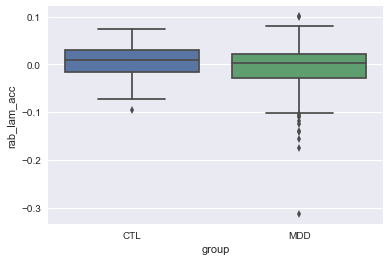

In [173]:
# Rab/Lam accuracy effect
sns.boxplot(flk_rl_use.rab_lam_acc,groupby=flk_rl_use.group,names=['Control','MDD'])

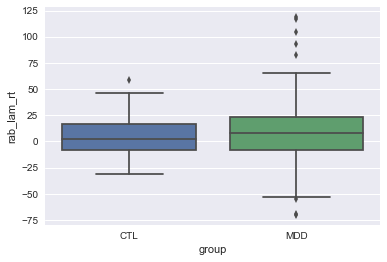

In [174]:
# Rab/Lam RT effect
sns.boxplot(flk_rl_use.rab_lam_rt,groupby=flk_rl_use.group,names=['Control','MDD'])

In [175]:
%Rpush flk_rl_use

In [176]:
# For Rab/Lam effect on accuracy, see if effect is greater than zero in each group, and then check group diff.
%R flk_rl_use.ctrl <- subset(flk_rl_use,group == 'CTL')
%R flk_rl_use.mdd <- subset(flk_rl_use,group == 'MDD')
%R print(t.test(flk_rl_use.ctrl$rab_lam_acc,mu=0)) # Controls, p = .38
%R print(t.test(flk_rl_use.mdd$rab_lam_acc,mu=0)) # MDD, p = .11
%R print(t.test(rab_lam_acc ~ group,flk_rl_use)) # No group difference, p = 0.15


	One Sample t-test

data:  flk_rl_use.ctrl$rab_lam_acc
t = 0.88374, df = 33, p-value = 0.3832
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.007722999  0.019584833
sample estimates:
  mean of x 
0.005930917 




	One Sample t-test

data:  flk_rl_use.mdd$rab_lam_acc
t = -1.5877, df = 246, p-value = 0.1136
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.011052353  0.001186524
sample estimates:
   mean of x 
-0.004932915 




	Welch Two Sample t-test

data:  rab_lam_acc by group
t = 1.469, df = 48.362, p-value = 0.1483
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.004002741  0.025730405
sample estimates:
mean in group CTL mean in group MDD 
      0.005930917      -0.004932915 



In [177]:
# For Rab/Lam effect on RT, see if effect is greater than zero in each group, and then check group diff.
%R print(t.test(flk_rl_use.ctrl$rab_lam_rt,mu=0)) # Controls, p = .14
%R print(t.test(flk_rl_use.mdd$rab_lam_rt,mu=0)) # MDD, p < .001 (evidence of post-error slowing)
%R print(t.test(rab_lam_rt ~ group,flk_rl_use)) # No group difference, p = 0.33


	One Sample t-test

data:  flk_rl_use.ctrl$rab_lam_rt
t = 1.5208, df = 33, p-value = 0.1378
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -1.917347 13.270416
sample estimates:
mean of x 
 5.676535 




	One Sample t-test

data:  flk_rl_use.mdd$rab_lam_rt
t = 5.5904, df = 246, p-value = 6.006e-08
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
  6.320765 13.197698
sample estimates:
mean of x 
 9.759232 




	Welch Two Sample t-test

data:  rab_lam_rt by group
t = -0.9908, df = 48.704, p-value = 0.3267
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -12.36461   4.19922
sample estimates:
mean in group CTL mean in group MDD 
         5.676535          9.759232 



In [179]:
flk_ddm_clin_s1 = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_DDM_Clin_s1_Mar-03-1058AM-2017.csv')

In [180]:
# Get trial-level data for subjects who pass the flanker qc check
flk_ddm_use = flk_ddm_clin_s1[~flk_ddm_clin_s1.ProjectSpecificID.isin(flk_qc_fails)]

In [181]:
len(flk_ddm_use)

105350

In [182]:
# Confirming we have trial-level data from 35 controls and 266 depressed (with flanker_qc == 1)
bygroup = flk_ddm_use.groupby('group')
bygroup.ProjectSpecificID.nunique()

group
CTL     35
MDD    266
Name: ProjectSpecificID, dtype: int64

In [183]:
# For any trial-level analysis of Gratton or Rab/Lam, no need to worry about outliers or no-response trials b/c
# Flanker_proc.clean() handles them. But you do need to exclude those trials for the flanker interferene analyses.
# So let's create a df with no outliers and no no-response trials
flk_ddm_use_clean = flk_ddm_use[~(flk_ddm_use.outlier == 1.0) & ~(pd.isnull(flk_ddm_use.rt))]
flk_ddm_use_clean.to_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/flk_ddm_use_clean.csv')

In [184]:
len(flk_ddm_use_clean)

103801

In [185]:
# Give me mean accuracy by Stimulus for each group
by_grp_stim = flk_ddm_use_clean.groupby(['group','stimulus'])
by_grp_stim['accuracy'].mean()

group  stimulus
CTL    CON         0.987780
       INC         0.772006
MDD    CON         0.984785
       INC         0.791639
Name: accuracy, dtype: float64

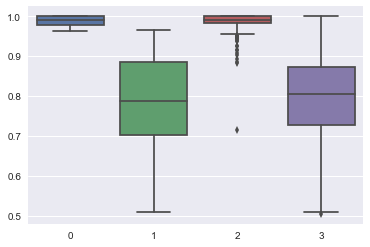

In [186]:

## Now boxplots of Group x Stimulus for accuracy . . . 

ctrl_con_acc = []
ctrl_inc_acc = []
mdd_con_acc = []
mdd_inc_acc = []

flk_acc_grpd = flk_ddm_use_clean.groupby(['group','stimulus','ProjectSpecificID'])['accuracy'].mean()

for key in flk_acc_grpd.keys():
    if key[0] == 'CTL' and key[1] == 'CON':
        ctrl_con_acc.append(flk_acc_grpd[key])
    elif key[0] == 'CTL' and key[1] == 'INC':
        ctrl_inc_acc.append(flk_acc_grpd[key])
    elif key[0] == 'MDD' and key[1] == 'CON':
        mdd_con_acc.append(flk_acc_grpd[key])
    elif key[0] == 'MDD' and key[1] == 'INC':
        mdd_inc_acc.append(flk_acc_grpd[key])

flk_acc_4plot = [ctrl_con_acc,ctrl_inc_acc,mdd_con_acc,mdd_inc_acc]
#ctrl_con_acc
sns.boxplot(data = flk_acc_4plot,names=['Ctrl:CON','Ctrl:INC','MDD:CON','MDD:INC'])

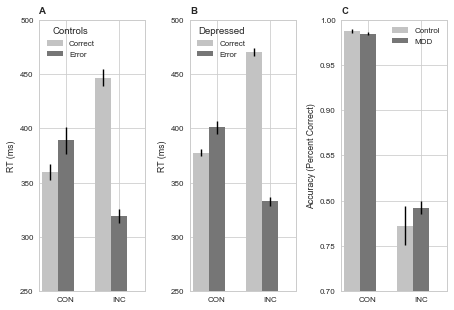

In [187]:
## Now boxplots of Group x Stimulus for accuracy. Initially very excited about factorplot (below), but having trouble
# getting it to plot a couple of things. More importantly, the SEM bars it generates are almost certainly not taking
# into account the number of subjects in each condition, but are instead working with N data points. That would 
# mislead most readers. Developed a better solution here--saved as Figure 2 for Psychological Medicine.

sns.set_style('whitegrid')
sns.set_context('paper')

## Plotting accuracy (Group x Stimulus)

ctrl_con_acc = []
ctrl_inc_acc = []
mdd_con_acc = []
mdd_inc_acc = []

flk_acc_means = flk_ddm_use_clean.groupby(['group','stimulus','ProjectSpecificID'])['accuracy'].mean()

for key in flk_acc_means.keys():
    if key[0] == 'CTL' and key[1] == 'CON':
        ctrl_con_acc.append(flk_acc_means[key])
            
    elif key[0] == 'CTL' and key[1] == 'INC':
        ctrl_inc_acc.append(flk_acc_means[key])
            
    elif key[0] == 'MDD' and key[1] == 'CON':
        mdd_con_acc.append(flk_acc_means[key])
            
    elif key[0] == 'MDD' and key[1] == 'INC':
        mdd_inc_acc.append(flk_acc_means[key])
        
ctrl_con_acc_se = sp.stats.sem(ctrl_con_acc)
ctrl_inc_acc_se = sp.stats.sem(ctrl_inc_acc)
mdd_con_acc_se = sp.stats.sem(mdd_con_acc)
mdd_inc_acc_se = sp.stats.sem(mdd_inc_acc)

ctrl_acc_means = [np.mean(ctrl_con_acc), np.mean(ctrl_inc_acc)]
ctrl_acc_se = [ctrl_con_acc_se, ctrl_inc_acc_se]

mdd_acc_means = [np.mean(mdd_con_acc),np.mean(mdd_inc_acc)]
mdd_acc_se = [mdd_con_acc_se, mdd_inc_acc_se]

# Plot accuracy
index = [0.1,0.6]
index = np.asarray(index)
width = 0.15

fig = plt.figure()
ax1 = fig.add_subplot(133)
ax1.set_ylim([0.7,1.0])
ax1.set_xlim([0,1])
ctrl_acc_bars = ax1.bar(index,ctrl_acc_means,width,yerr=ctrl_acc_se,color='#C3C3C3',ecolor='black',label='Control')
mdd_acc_bars = ax1.bar(index+width,mdd_acc_means,width,yerr=mdd_acc_se,color='#767676',ecolor='black',label='MDD')
ax1.set_xticks([0.25,0.75])
ax1.set_xticklabels(['CON','INC'])
ax1.set_ylabel('Accuracy (Percent Correct)')
#ax1.text(-0.3,1.01,'A',fontweight='bold') # I like the flexibility of text vs. set_title, but cannot get it to plot ax2
ax1.set_title('C',loc='left',fontweight='bold')
acc_legend = ax1.legend(loc='upper right')

## Plotting RT (Stimulus x Accuracy): Controls

ctrl_con0_rt = []
ctrl_con1_rt = []
ctrl_inc0_rt = []
ctrl_inc1_rt = []

flk_rt_means = flk_ddm_use_clean.groupby(['group','stimulus','accuracy','ProjectSpecificID'])['rt'].mean()

for key in flk_rt_means.keys():
    if key[0] == 'CTL' and key[1] == 'CON' and key[2] == 0.0:
        ctrl_con0_rt.append(flk_rt_means[key])
            
    elif key[0] == 'CTL' and key[1] == 'CON' and key[2] == 1.0:
        ctrl_con1_rt.append(flk_rt_means[key])
            
    elif key[0] == 'CTL' and key[1] == 'INC' and key[2] == 0.0:
        ctrl_inc0_rt.append(flk_rt_means[key])
            
    elif key[0] == 'CTL' and key[1] == 'INC' and key[2] == 1.0:
        ctrl_inc1_rt.append(flk_rt_means[key])
        
ctrl_con0_rt_se = sp.stats.sem(ctrl_con0_rt)
ctrl_con1_rt_se = sp.stats.sem(ctrl_con1_rt)
ctrl_inc0_rt_se = sp.stats.sem(ctrl_inc0_rt)
ctrl_inc1_rt_se = sp.stats.sem(ctrl_inc1_rt)

ctrl_corr_rt_means = [np.mean(ctrl_con1_rt), np.mean(ctrl_inc1_rt)]
ctrl_corr_rt_se = [ctrl_con1_rt_se, ctrl_inc1_rt_se]

ctrl_err_rt_means = [np.mean(ctrl_con0_rt), np.mean(ctrl_inc0_rt)]
ctrl_err_rt_se = [ctrl_con0_rt_se, ctrl_inc0_rt_se]

# Now plot RT for the controls
ax2 = fig.add_subplot(131)
ax2.set_ylim([250,500])
ax2.set_xlim([0,1])
ctrl_corr_rt_bars = ax2.bar(index,ctrl_corr_rt_means,width,yerr=ctrl_corr_rt_se,
                           color='#C3C3C3',ecolor='black',label='Correct')
ctrl_err_rt_bars = ax2.bar(index+width,ctrl_err_rt_means,width,yerr=ctrl_err_rt_se,
                          color='#767676',ecolor='black',label='Error')
ax2.set_xticks([0.25,0.75])
ax2.set_xticklabels(['CON','INC'])
ax2.set_ylabel('RT (ms)')
ax2.set_title('A',loc='left',fontweight='bold')
acc_legend = ax2.legend(loc='upper left', title='Controls')

## Plotting RT (Stimulus x Accuracy): MDD

mdd_con0_rt = []
mdd_con1_rt = []
mdd_inc0_rt = []
mdd_inc1_rt = []

for key in flk_rt_means.keys():
    if key[0] == 'MDD' and key[1] == 'CON' and key[2] == 0.0:
        mdd_con0_rt.append(flk_rt_means[key])
            
    elif key[0] == 'MDD' and key[1] == 'CON' and key[2] == 1.0:
        mdd_con1_rt.append(flk_rt_means[key])
            
    elif key[0] == 'MDD' and key[1] == 'INC' and key[2] == 0.0:
        mdd_inc0_rt.append(flk_rt_means[key])
            
    elif key[0] == 'MDD' and key[1] == 'INC' and key[2] == 1.0:
        mdd_inc1_rt.append(flk_rt_means[key])
        
mdd_con0_rt_se = sp.stats.sem(mdd_con0_rt)
mdd_con1_rt_se = sp.stats.sem(mdd_con1_rt)
mdd_inc0_rt_se = sp.stats.sem(mdd_inc0_rt)
mdd_inc1_rt_se = sp.stats.sem(mdd_inc1_rt)

mdd_corr_rt_means = [np.mean(mdd_con1_rt), np.mean(mdd_inc1_rt)]
mdd_corr_rt_se = [mdd_con1_rt_se, mdd_inc1_rt_se]

mdd_err_rt_means = [np.mean(mdd_con0_rt), np.mean(mdd_inc0_rt)]
mdd_err_rt_se = [mdd_con0_rt_se, mdd_inc0_rt_se]

# Now plot RT for the MDD group
ax3 = fig.add_subplot(132)
ax3.set_ylim([250,500])
ax3.set_xlim([0,1])
mdd_corr_rt_bars = ax3.bar(index,mdd_corr_rt_means,width,yerr=mdd_corr_rt_se,
                           color='#C3C3C3',ecolor='black',label='Correct')
mdd_err_rt_bars = ax3.bar(index+width,mdd_err_rt_means,width,yerr=mdd_err_rt_se,
                          color='#767676',ecolor='black',label='Error')
ax3.set_xticks([0.25,0.75])
ax3.set_xticklabels(['CON','INC'])
ax3.set_ylabel('RT (ms)')
ax3.set_title('B',loc='left',fontweight='bold')
acc_legend = ax3.legend(loc='upper left', title='Depressed')

## Space the subplots correctly, show, and save
plt.tight_layout()
#plt.savefig('/Users/danieldillon/Work/Expts/EMBARC/Manuscripts/Flanker/Figures/Fig2.eps',format='eps',transparent=True)
plt.show()

In [188]:
# Correlation b/w CON and INC accuracy in each group
ctrl_acc_correl = pearsonr(ctrl_con_acc,ctrl_inc_acc)
mdd_acc_correl = pearsonr(mdd_con_acc,mdd_inc_acc)

print ('Ctrls: CON and INC acc, r = ' + '{:.2f}'.format(ctrl_acc_correl[0]) + ', p = ' + '{:.2f}'.format(ctrl_acc_correl[1]))
print ('MDD: CON and INC acc, r = ' + '{:.2f}'.format(mdd_acc_correl[0]) + ', p = ' + '{:.2f}'.format(mdd_acc_correl[1]))

Ctrls: CON and INC acc, r = 0.25, p = 0.15
MDD: CON and INC acc, r = 0.26, p = 0.00


In [189]:
list(flk_ddm_use_clean) #this is already pretty clean but it's killing rpy2

['ProjectSpecificID',
 'site',
 'subject',
 'session',
 'group',
 'block',
 'trial',
 'stimulus',
 'response',
 'accuracy',
 'rt',
 'feedback',
 'ln_rt',
 'outlier',
 'rab_lam',
 'gratton']

In [190]:
flk_ddm_use_clean_tight = flk_ddm_use_clean[['ProjectSpecificID', 'site','group', 'stimulus','accuracy']]
flk_ddm_use_clean_tight.head()

,ProjectSpecificID,site,group,stimulus,accuracy
0,CU0009,CU,CTL,INC,1.0
1,CU0009,CU,CTL,CON,1.0
2,CU0009,CU,CTL,INC,0.0
3,CU0009,CU,CTL,CON,1.0
4,CU0009,CU,CTL,INC,1.0


In [191]:
# Using the trial-level data, let's run a linear mixed-model in which we predict accuracy with Site and Group*Stimulus
# Group*Stimulus would ideally show that INC trials are especially tough for MDD subjects; based on the boxplots, 
# seems more likely to show that MDDs are worse than controls on CON trials (and maybe better on INC trials).
# I have ProjectSpecificID as a random effect: each subject gets his or her own intercept
# The two stimulus conditions--CON and INC--are exhaustive, so Stimulus is a fixed effect
# The two groups are exhaustive for this study, so Group is a fixed effect
# The four sites are exhaustive for this study, so Site is a fixed effect. I could imagine it being random b/c these
# four sites are not exhaustive in the same way that the two groups and stimuli are, but I think this approach is ok.
# Our hypothesis is that Group and Stimulus interact, but Site is not expected to and would be uninterpretable.
# So no interaction with Site is specified.
# Returns an effect of Stimulus (INC < CON) and Group x Stimulus, due to MDD > Ctrl for INC (but reverse for CON)

%Rpush flk_ddm_use_clean
%R library(lmerTest)
%R flk_ddm_use_clean$group <- as.factor(flk_ddm_use_clean$group)
%R flk_ddm_use_clean$site <- as.factor(flk_ddm_use_clean$site)
%R flk_ddm_use_clean$stimulus <- as.factor(flk_ddm_use_clean$stimulus)

# Create the model
%R flk_ddm_use_clean.acc1 = glmer(accuracy ~ site + group*stimulus + (1|ProjectSpecificID), data=flk_ddm_use_clean, family=binomial)

# Print the results:
%R print(summary(flk_ddm_use_clean.acc1)) # takes a while (~20 mins), just let it run


Error in is.factor(x) : object 'flk_ddm_use_cleanMDD' not found


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: accuracy ~ site + group * stimulus + (1 | ProjectSpecificID)
   Data: flk_ddm_use_clean

     AIC      BIC   logLik deviance df.resid 
 44838.6  44915.0 -22411.3  44822.6   103793 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-22.8119   0.0902   0.1221   0.2649   1.5184 

Random effects:
 Groups            Name        Variance Std.Dev.
 ProjectSpecificID (Intercept) 0.5635   0.7507  
Number of obs: 103801, groups:  ProjectSpecificID, 301

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)            4.4523     0.1807  24.633  < 2e-16 ***
siteMG                 0.1515     0.1362   1.113  0.26589    
siteTX                 0.2463     0.1153   2.136  0.03264 *  
siteUM                 0.2554     0.1311   1.948  0.05140 .  
groupMDD              -0.1826     0.1739  -1.050  0.29381    
stimulusINC      

In [192]:
%R print(lmerTest::anova(flk_ddm_use_clean.acc1)) 

Analysis of Variance Table
               Df Sum Sq Mean Sq   F value
site            3    4.6     1.5    1.5416
group           1    2.0     2.0    1.9914
stimulus        1 7235.2  7235.2 7235.1510
group:stimulus  1    8.1     8.1    8.0845


In [202]:
# Okay, let's run the more traditional Site x Group x Stim ANOVA

%Rpush flk_ddm_use_clean
%R library(afex)
%R flk_ddm_aov.acc <- aov_ez("ProjectSpecificID", dv = "accuracy", data = flk_ddm_use_clean, between = c("site","group"),within="stimulus",anova_table=list(correction="none", es = "none"))
%R print(flk_ddm_aov.acc)

# The stim finding was the same as the first half of the data, but the site x group x stimulus interaction is new

Anova Table (Type 3 tests)

Response: accuracy
               Effect     df  MSE          F p.value
1                site 3, 293 0.01       0.52     .67
2               group 1, 293 0.01       0.45     .50
3          site:group 3, 293 0.01     3.49 *     .02
4            stimulus 1, 293 0.01 404.55 ***  <.0001
5       site:stimulus 3, 293 0.01       0.97     .41
6      group:stimulus 1, 293 0.01       1.14     .29
7 site:group:stimulus 3, 293 0.01    4.33 **    .005


In [195]:
# To examine the interaction, trying out the Post-Hoc Interaction Analysis (PHIA) package from R
%R library(phia)

array(['phia', 'car', 'lmerTest', 'ppcor', 'MASS', 'afex', 'reshape2',
       'lme4', 'Matrix', 'lsmeans', 'estimability', 'tools', 'stats',
       'graphics', 'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='<U12')

In [196]:
# Print adjusted means for the Group x Site x Stimulus interaction. TODO: Need to follow up on this
# Note that these adjusted means are not identical to the raw means.
%R print(interactionMeans(flk_ddm_use_clean.acc1, factors=c('group','stimulus','site')))

   site group stimulus adjusted mean SE of link
1    CU   CTL      CON     0.9884825 0.18074341
2    MG   CTL      CON     0.9900856 0.18665236
3    TX   CTL      CON     0.9909745 0.18013491
4    UM   CTL      CON     0.9910549 0.18274775
5    CU   MDD      CON     0.9862075 0.08944514
6    MG   MDD      CON     0.9881235 0.11448912
7    TX   MDD      CON     0.9891864 0.08712346
8    UM   MDD      CON     0.9892825 0.10861365
9    CU   CTL      INC     0.7659612 0.15382736
10   MG   CTL      INC     0.7920198 0.16051727
11   TX   CTL      INC     0.8072089 0.15315578
12   UM   CTL      INC     0.8086105 0.15610218
13   CU   MDD      INC     0.7914153 0.08399898
14   MG   MDD      INC     0.8153230 0.11031668
15   TX   MDD      INC     0.8291773 0.08134839
16   UM   MDD      INC     0.8304528 0.10401788


In [197]:
# Simple effect of Stimulus at each Group (should be highly sig). Yup, looks fine.
%R print(testInteractions(flk_ddm_use_clean.acc1,fixed='group',across='stimulus'))

Chisq Test: 
P-value adjustment method: holm
      Value Df   Chisq Pr(>Chisq)    
CTL 0.96327  1  901.18  < 2.2e-16 ***
MDD 0.94961  1 6451.40  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [198]:
# Now try simple effect of Group at each level of Stimulus. Possible difference on INC trials.
# ***The strong group difference at the first point of analysis has reduced to a trend here***
# ***Actually not even a trend with the glm (it was with lmer), is that right?***

%R print(testInteractions(flk_ddm_use_clean.acc1,fixed='stimulus',across='group'))

Chisq Test: 
P-value adjustment method: holm
      Value Df  Chisq Pr(>Chisq)
CON 0.54551  1 1.1021     0.5876
INC 0.46311  1 1.0759     0.5876


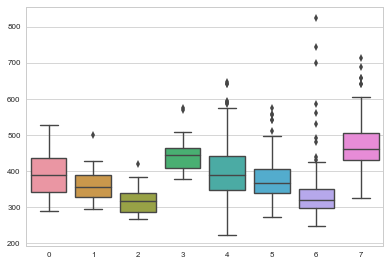

In [199]:
# Now a boxplot on RT--see below. Interesting, shows that RT is faster for correct vs. incorrect CON trials, while
# RT is slower for correct vs. incorrect INC trials. Similar pattern in both groups

# First, group the RT data
flk_rt_grpd = flk_ddm_use_clean.groupby(['group','stimulus','accuracy','ProjectSpecificID'])['rt'].mean()

# Set-up containers for summary stats by Group x Stimulus x Accuracy
ctrl_con_err = []
ctrl_con_corr = []
ctrl_inc_err = []
ctrl_inc_corr = []

mdd_con_err = []
mdd_con_corr = []
mdd_inc_err = []
mdd_inc_corr = []

# Fill the containers
for key in flk_rt_grpd.keys():
    
    # Gather the controls' data
    if key[0] == 'CTL' and key[1] == 'CON' and key[2] == 0.0:
        ctrl_con_err.append(flk_rt_grpd[key])
    elif key[0] == 'CTL' and key[1] == 'CON' and key[2] == 1.0:
        ctrl_con_corr.append(flk_rt_grpd[key])
    elif key[0] == 'CTL' and key[1] == 'INC' and key[2] == 0.0:
        ctrl_inc_err.append(flk_rt_grpd[key])
    elif key[0] == 'CTL' and key[1] == 'INC' and key[2] == 1.0:
        ctrl_inc_corr.append(flk_rt_grpd[key])
        
    # Now the MDD data
    if key[0] == 'MDD' and key[1] == 'CON' and key[2] == 0.0:
        mdd_con_err.append(flk_rt_grpd[key])
    elif key[0] == 'MDD' and key[1] == 'CON' and key[2] == 1.0:
        mdd_con_corr.append(flk_rt_grpd[key])
    elif key[0] == 'MDD' and key[1] == 'INC' and key[2] == 0.0:
        mdd_inc_err.append(flk_rt_grpd[key])
    elif key[0] == 'MDD' and key[1] == 'INC' and key[2] == 1.0:
        mdd_inc_corr.append(flk_rt_grpd[key])

flk_rt_4plot = [ctrl_con_err, ctrl_con_corr, ctrl_inc_err, ctrl_inc_corr, 
                mdd_con_err, mdd_con_corr, mdd_inc_err, mdd_inc_corr]

sns.boxplot(data = flk_rt_4plot,names=['C_con_0','C_con_1','C_inc_0','C_inc_1', 
                'D_con_0','D_con_1','D_inc_0','D_inc_1'])

In [200]:
# Now let's run a linear mixed-model in which we predict RT with Site and Group*Stimulus*Accuracy

# Create the model
%R flk_ddm_use_clean.rt = lmer(rt ~ site + group*stimulus*accuracy + (1|ProjectSpecificID), data=flk_ddm_use_clean)

# Print the results: 
%R print(summary(flk_ddm_use_clean.rt))
# ***Pretty much the same as time 1, except siteUM is significant here***

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: rt ~ site + group * stimulus * accuracy + (1 | ProjectSpecificID)
   Data: flk_ddm_use_clean

REML criterion at convergence: 1160931

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5096 -0.5855 -0.1275  0.4258 11.9223 

Random effects:
 Groups            Name        Variance Std.Dev.
 ProjectSpecificID (Intercept) 2600     50.99   
 Residual                      4152     64.43   
Number of obs: 103801, groups:  ProjectSpecificID, 301

Fixed effects:
                                Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                    3.925e+02  1.196e+01  6.020e+02  32.806  < 2e-16
siteMG                         7.267e-01  8.845e+00  2.960e+02   0.082  0.93457
siteTX                         8.496e+00  7.502e+00  2.960e+02   1.133  0.25834
siteUM                        -1.967e+01  8.523e+00  2.960e+02  -2.308  0.02168
groupMDD       

In [201]:
# Does having accuracy as a factor affect the results at all? Let's find out. Nope, doesn't change 
# the results (would have been strange if it had).

%R flk_ddm_use_clean$accuracy <- as.factor(flk_ddm_use_clean$accuracy)

# Create the model
%R flk_ddm_use_clean.rt2 = lmer(rt ~ site + group*stimulus*accuracy + (1|ProjectSpecificID), data=flk_ddm_use_clean)

# Print the results: 
%R print(summary(flk_ddm_use_clean.rt2))

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: rt ~ site + group * stimulus * accuracy + (1 | ProjectSpecificID)
   Data: flk_ddm_use_clean

REML criterion at convergence: 1160931

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5096 -0.5855 -0.1275  0.4258 11.9223 

Random effects:
 Groups            Name        Variance Std.Dev.
 ProjectSpecificID (Intercept) 2600     50.99   
 Residual                      4152     64.43   
Number of obs: 103801, groups:  ProjectSpecificID, 301

Fixed effects:
                                 Estimate Std. Error         df t value
(Intercept)                     3.925e+02  1.196e+01  6.020e+02  32.806
siteMG                          7.267e-01  8.845e+00  2.960e+02   0.082
siteTX                          8.496e+00  7.502e+00  2.960e+02   1.133
siteUM                         -1.967e+01  8.523e+00  2.960e+02  -2.308
groupMDD                       -5.953e+00  1.154e+01  7

In [203]:
# Let's look at the means defined by the Group x Stimulus interaction
# Again, these are adjusted for the other terms in the model and are not equal to the raw means.
%R print(interactionMeans(flk_ddm_use_clean.rt2, factors=c('group','stimulus')))

  group stimulus adjusted mean SE of link
1   CTL      CON      375.3587   9.235127
2   MDD      CON      379.8245   3.421905
3   CTL      INC      384.8699   8.706536
4   MDD      INC      399.7945   3.275408


In [204]:
# First, test the INC vs. CON difference in each group. Should be strong for both. Yup
%R print(testInteractions(flk_ddm_use_clean.rt2,fixed='group',across='stimulus'))

Chisq Test: 
P-value adjustment method: holm
       Value Df    Chisq Pr(>Chisq)    
CTL  -9.5112  1   7.3354   0.006761 ** 
MDD -19.9700  1 288.7626  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [205]:
# Now test group differences for INC and CON. Maybe a stronger difference in INC?
# *** Went from a trend (p = .07) at the first time of analysis to nothing here***
%R print(testInteractions(flk_ddm_use_clean.rt2,fixed='stimulus',across='group'))

Chisq Test: 
P-value adjustment method: holm
       Value Df  Chisq Pr(>Chisq)
CON  -4.4658  1 0.2047     0.6509
INC -14.9246  1 2.5621     0.2189


In [206]:
# Let's look at the means defined by the Group x Accuracy interaction
%R print(interactionMeans(flk_ddm_use_clean.rt2, factors=c('group','accuracy')))

  group accuracy adjusted mean SE of link
1   CTL        0      356.0916   9.289984
2   MDD        0      357.7416   3.443906
3   CTL        1      404.1369   8.650409
4   MDD        1      421.8774   3.253623


In [207]:
# Now test the correct vs. error difference in each group. Should be strong for both. Yup.
%R print(testInteractions(flk_ddm_use_clean.rt2,fixed='group',across='accuracy'))

Chisq Test: 
P-value adjustment method: holm
      Value Df   Chisq Pr(>Chisq)    
CTL -48.045  1  185.91  < 2.2e-16 ***
MDD -64.136  1 2940.86  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [208]:
# Finally, run b/w group tests for correct vs. error trials. Potential for a difference on correct trials. 
# *** Was significant (p = .02) at the first time of analysis, now is not***
%R print(testInteractions(flk_ddm_use_clean.rt2,fixed='accuracy',across='group'))

Chisq Test: 
P-value adjustment method: holm
   Value Df  Chisq Pr(>Chisq)
0  -1.65  1 0.0276      0.868
1 -17.74  1 3.6671      0.111


In [209]:
# Now let's run the more traditional Site x Group x Stim x Accuracy ANOVA on RT

%R flk_ddm_use_clean$accuracy <- as.factor(flk_ddm_use_clean$accuracy)
%R flk_ddm_aov.rt <- aov_ez("ProjectSpecificID", dv = "rt", data = flk_ddm_use_clean, between = c("site","group"),within=c("stimulus","accuracy"),anova_table=list(correction="none", es = "none"))
%R print(flk_ddm_aov.rt)

Anova Table (Type 3 tests)

Response: rt
                         Effect     df      MSE          F p.value
1                          site 3, 207 11542.30       1.32     .27
2                         group 1, 207 11542.30       1.94     .17
3                    site:group 3, 207 11542.30       0.96     .41
4                      stimulus 1, 207  1428.51     5.49 *     .02
5                 site:stimulus 3, 207  1428.51       0.75     .52
6                group:stimulus 1, 207  1428.51       0.59     .44
7           site:group:stimulus 3, 207  1428.51       0.20     .89
8                      accuracy 1, 207  1515.63 147.17 ***  <.0001
9                 site:accuracy 3, 207  1515.63       0.42     .74
10               group:accuracy 1, 207  1515.63       1.87     .17
11          site:group:accuracy 3, 207  1515.63       0.20     .90
12            stimulus:accuracy 1, 207  1521.79 334.07 ***  <.0001
13       site:stimulus:accuracy 3, 207  1521.79       0.26     .86
14      group:stimulu

In [210]:
# Find out which subjects have empty cells
flk_diagnost = flk_ddm_use_clean.groupby(['ProjectSpecificID','stimulus','accuracy'])

subs = flk_ddm_use_clean.ProjectSpecificID.unique()
bad_subs = []

for sub in subs:
    
    df = flk_ddm_use_clean[(flk_ddm_use_clean.ProjectSpecificID == sub)]
    con0_rt = df[(df.stimulus == 'CON') & (df.accuracy == 0.0)]['rt'].mean()
    con1_rt = df[(df.stimulus == 'CON') & (df.accuracy == 1.0)]['rt'].mean()
    inc0_rt = df[(df.stimulus == 'INC') & (df.accuracy == 0.0)]['rt'].mean()
    inc1_rt = df[(df.stimulus == 'INC') & (df.accuracy == 1.0)]['rt'].mean()

    if pd.isnull(con0_rt) or pd.isnull(con1_rt) or pd.isnull(inc0_rt) or pd.isnull(inc1_rt):
        bad_subs.append(sub)

for bsub in bad_subs:
    print ('Subject ' + str(bsub) + ' has at least 1 empty cell.')

Subject CU0009 has at least 1 empty cell.
Subject CU0019 has at least 1 empty cell.
Subject CU0021 has at least 1 empty cell.
Subject CU0029 has at least 1 empty cell.
Subject CU0030 has at least 1 empty cell.
Subject CU0036 has at least 1 empty cell.
Subject CU0041 has at least 1 empty cell.
Subject CU0069 has at least 1 empty cell.
Subject CU0073 has at least 1 empty cell.
Subject CU0074 has at least 1 empty cell.
Subject CU0077 has at least 1 empty cell.
Subject CU0087 has at least 1 empty cell.
Subject CU0100 has at least 1 empty cell.
Subject CU0102 has at least 1 empty cell.
Subject CU0108 has at least 1 empty cell.
Subject CU0115 has at least 1 empty cell.
Subject CU0121 has at least 1 empty cell.
Subject CU0125 has at least 1 empty cell.
Subject CU0127 has at least 1 empty cell.
Subject CU0130 has at least 1 empty cell.
Subject CU0131 has at least 1 empty cell.
Subject MG0006 has at least 1 empty cell.
Subject MG0021 has at least 1 empty cell.
Subject MG0026 has at least 1 empt

In [211]:
# There is a Gratton effect, but it does not interact with Group.

%R grt_use = subset(flk_ddm_use_clean, gratton > 0)
%R grt_use$gratton <- as.factor(grt_use$gratton)
%R grt_use$accuracy <- as.numeric(grt_use$accuracy)

%R grt_mod.acc1 <-  aov_ez("ProjectSpecificID", dv = "accuracy", data = grt_use, between = c("group"),within=c("gratton"),anova_table=list(correction="none", es = "none"))
%R print(grt_mod.acc1)


Anova Table (Type 3 tests)

Response: accuracy
         Effect     df  MSE         F p.value
1         group 1, 299 0.03      0.94     .33
2       gratton 1, 299 0.01 47.19 ***  <.0001
3 group:gratton 1, 299 0.01      0.00     .98


In [212]:
# Let's get descriptives on the Gratton accuracy effect.
# Gratton '1' = con_inc
# Gratton '2' = inc_inc

grt_use = flk_ddm_use_clean[flk_ddm_use_clean.gratton > 0]
grt_grouped = grt_use.groupby(['group','gratton'])
grt_grouped['accuracy'].mean() # Confirms the expected effect in both groups. Slightly bigger in controls

group  gratton
CTL    1          0.758782
       2          0.843177
MDD    1          0.779824
       2          0.863073
Name: accuracy, dtype: float64

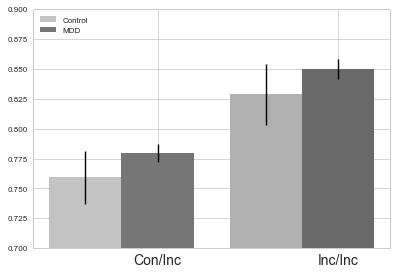

In [213]:
# Now a Gratton accuracy barplot; looks similar to the time one analysis
grt_grp_acc = grt_use.groupby(['group','gratton','ProjectSpecificID'])['accuracy'].mean()

ctrl_grt1_acc = []
ctrl_grt2_acc = []
mdd_grt1_acc = []
mdd_grt2_acc = []

for key in grt_grp_acc.keys():
    if key[0] == 'CTL' and key[1] == 1:
        ctrl_grt1_acc.append(grt_grp_acc[key])
    elif key[0] == 'CTL' and key[1] == 2:
        ctrl_grt2_acc.append(grt_grp_acc[key])
    elif key[0] == 'MDD' and key[1] == 1:
        mdd_grt1_acc.append(grt_grp_acc[key])
    elif key[0] == 'MDD' and key[1] == 2:
        mdd_grt2_acc.append(grt_grp_acc[key])

ctrl_grt1_acc_se = sp.stats.sem(ctrl_grt1_acc)
ctrl_grt2_acc_se = sp.stats.sem(ctrl_grt2_acc)
mdd_grt1_acc_se = sp.stats.sem(mdd_grt1_acc)
mdd_grt2_acc_se = sp.stats.sem(mdd_grt2_acc)

ctrl_grt_acc_means = [np.mean(ctrl_grt1_acc),np.mean(ctrl_grt2_acc)]
ctrl_grt_acc_se = [np.mean(ctrl_grt1_acc_se),np.mean(ctrl_grt2_acc_se)]

mdd_grt_acc_means = [np.mean(mdd_grt1_acc),np.mean(mdd_grt2_acc)]
mdd_grt_acc_se = [np.mean(mdd_grt1_acc_se),np.mean(mdd_grt2_acc_se)]

# Make the figure
index = [0.05,0.55]
index = np.asarray(index)
width = 0.2

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylim([0.7,0.9])
ax1.bar(index,ctrl_grt_acc_means,width,color=['#C3C3C3','#B0B0B0'],yerr=ctrl_grt_acc_se,ecolor='black',label='Control')
ax1.bar(index+width,mdd_grt_acc_means,width,color=['#767676','#6A6A6A'],yerr=mdd_grt_acc_se,ecolor='black',label='MDD')
ax1.set_xticks([0.25,0.75])
ax1.set_xticklabels(['Con/Inc','Inc/Inc'],fontsize=14)
ax1.legend(loc='upper left') 

In [214]:
# Now Gratton RT

# Descriptives. Gratton '1' = con/inc and Gratton '2' = inc/inc, so we'd expected to see faster RT on Gratton 2 
# which we do not. But this may not actually be that tough to explain . . . look at the plot from the G x S x A
# ANOVA: on INC trials, errors are much faster than correct responses. The error rate is significantly higher on
# Con/Inc (gratton 1) trials than on Inc/Inc (gratton 2) trials--see the plot above. Since errors are associated
# with faster RT than correct responses on INC trials, it is not surprising that the condition with a higher error
# rate also has a shorter mean RT. 

grt_grouped['rt'].mean()

group  gratton
CTL    1          414.955211
       2          428.727088
MDD    1          438.418450
       2          445.938005
Name: rt, dtype: float64

In [215]:
grt_grouped['ProjectSpecificID'].nunique()

group  gratton
CTL    1           35
       2           35
MDD    1          266
       2          266
Name: ProjectSpecificID, dtype: int64

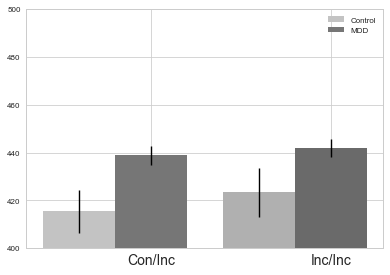

In [216]:
# Now a Gratton RT barplot. Looks the same as time 1

grt_grp_rt = grt_use.groupby(['group','gratton','ProjectSpecificID'])['rt'].mean()

ctrl_grt1_rt = []
ctrl_grt2_rt = []
mdd_grt1_rt = []
mdd_grt2_rt = []

for key in grt_grp_rt.keys():
    if key[0] == 'CTL' and key[1] == 1:
        ctrl_grt1_rt.append(grt_grp_rt[key])
    elif key[0] == 'CTL' and key[1] == 2:
        ctrl_grt2_rt.append(grt_grp_rt[key])
    elif key[0] == 'MDD' and key[1] == 1:
        mdd_grt1_rt.append(grt_grp_rt[key])
    elif key[0] == 'MDD' and key[1] == 2:
        mdd_grt2_rt.append(grt_grp_rt[key])

ctrl_grt1_rt_se = sp.stats.sem(ctrl_grt1_rt)
ctrl_grt2_rt_se = sp.stats.sem(ctrl_grt2_rt)
mdd_grt1_rt_se = sp.stats.sem(mdd_grt1_rt)
mdd_grt2_rt_se = sp.stats.sem(mdd_grt2_rt)

ctrl_grt_rt_means = [np.mean(ctrl_grt1_rt),np.mean(ctrl_grt2_rt)]
mdd_grt_rt_means = [np.mean(mdd_grt1_rt),np.mean(mdd_grt2_rt)]

ctrl_grt_rt_se = [ctrl_grt1_rt_se, ctrl_grt2_rt_se]
mdd_grt_rt_se = [mdd_grt1_rt_se, mdd_grt2_rt_se]

# Plot
index = [0.05,0.55]
index = np.asarray(index)
width = 0.2

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylim([400,500])
ax1.bar(index,ctrl_grt_rt_means,width,color=['#C3C3C3','#B0B0B0'],yerr=ctrl_grt_rt_se,ecolor='black',label='Control')
ax1.bar(index+width,mdd_grt_rt_means,width,color=['#767676','#6A6A6A'],yerr=mdd_grt_rt_se,ecolor='black',label='MDD')
ax1.set_xticks([0.25,0.75])
ax1.set_xticklabels(['Con/Inc','Inc/Inc'],fontsize=14)
ax1.legend()

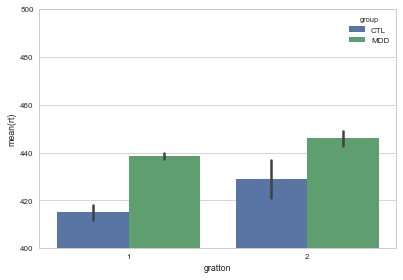

In [217]:
# same thing but with seaborn
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylim([400,500])
sns.barplot('gratton','rt','group',grt_use)

In [218]:
# Control means when data are averaged by subject first
ctrl_grt_rt_means

[415.3887636598426, 423.39207507245322]

In [219]:
# MDD means when data are averaged by subject first
mdd_grt_rt_means

[438.87270569111428, 441.78314789601274]

In [220]:
# Means by Group and Condition, but with no averageing within subjects.
grt_grouped['rt'].mean()

group  gratton
CTL    1          414.955211
       2          428.727088
MDD    1          438.418450
       2          445.938005
Name: rt, dtype: float64

In [221]:
# Okay, now a Group x TrialType ANOVA on the Gratton RT effect. **This comment doesn't seem to fit the actual ANOVA,right?**
# the TrialType effect is a trend at p = .09.
# %R grt_use = subset(flk_ddm_use_clean, gratton > 0)
# %R grt_use$gratton <- as.factor(grt_use$gratton)
# %R grt_use$accuracy <- as.numeric(grt_use$accuracy)

%R grt_mod.rt1 <-  aov_ez("ProjectSpecificID", dv = "rt", data = grt_use, between = c("group"),within=c("gratton"),anova_table=list(correction="none", es = "none"))
%R print(grt_mod.rt1)

Anova Table (Type 3 tests)

Response: rt
         Effect     df     MSE       F p.value
1         group 1, 299 7555.19  3.59 +     .06
2       gratton 1, 299  233.49 7.89 **    .005
3 group:gratton 1, 299  233.49    1.72     .19


In [222]:
# For the Rabbitt/Laming effect, first need to drop subjects who fail the QC check
# Identify the subjects who failed the RL QC
rl_qc_fail = flk_clin_s1[(flk_clin_s1.rab_lam_qc == 0)]
rl_qc_fails = rl_qc_fail.ProjectSpecificID.unique()

#Drop them from flk_ddm_use_clean
flk_ddm_rl = flk_ddm_use_clean[~(flk_ddm_use_clean.ProjectSpecificID.isin(rl_qc_fails))]

In [223]:
bygroup_rl = flk_ddm_rl.groupby('group')
bygroup_rl.ProjectSpecificID.nunique()

group
CTL     34
MDD    247
Name: ProjectSpecificID, dtype: int64

In [224]:
# Now run an ANOVA, generate descriptives, and give me a barplot for the Rabbitt/Laming effect on accuracy.
# ANOVA returns nothing significant.
rl_use = flk_ddm_rl[~(flk_ddm_rl.rab_lam == 0)]
%Rpush rl_use
%Rpush flk_ddm_rl
%R rl_use = subset(flk_ddm_rl, rab_lam > 0)
%R rl_use$rab_lam <- as.factor(rl_use$rab_lam)
%R rl_use$group <- as.factor(rl_use$group)
%R rl_mod.acc1 <- aov_ez("ProjectSpecificID",dv="accuracy", within=c("rab_lam"), between=c("group"), data=rl_use, anova_table=list(correction="none", es = "none"))
%R print(rl_mod.acc1)


Error in is.factor(x) : object 'rl_useMDD' not found


Anova Table (Type 3 tests)

Response: accuracy
         Effect     df  MSE    F p.value
1         group 1, 279 0.00 0.69     .41
2       rab_lam 1, 279 0.00 0.01     .91
3 group:rab_lam 1, 279 0.00 1.54     .21


In [225]:
# Rabbitt/Laming effect on accuracy looks miniscule (not averaged w/in subs)
bygroup_rl = rl_use.groupby(['group','rab_lam'])
bygroup_rl['accuracy'].mean()

group  rab_lam
CTL    1          0.955628
       2          0.965957
MDD    1          0.948397
       2          0.964742
Name: accuracy, dtype: float64

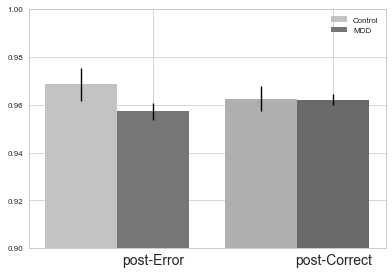

In [226]:
# Make the 'classic' barplot (averaged w/in subjects); looks the same as at time 1

rl_grp_acc = rl_use.groupby(['group','rab_lam','ProjectSpecificID'])['accuracy'].mean()

ctrl_rl1_acc = []
ctrl_rl2_acc = []
mdd_rl1_acc = []
mdd_rl2_acc = []

for key in rl_grp_acc.keys():
    if key[0] == 'CTL' and key[1] == 1:
        ctrl_rl1_acc.append(rl_grp_acc[key])
    elif key[0] == 'CTL' and key[1] == 2:
        ctrl_rl2_acc.append(rl_grp_acc[key])
    elif key[0] == 'MDD' and key[1] == 1:
        mdd_rl1_acc.append(rl_grp_acc[key])
    elif key[0] == 'MDD' and key[1] == 2:
        mdd_rl2_acc.append(rl_grp_acc[key])

ctrl_rl1_acc_se = sp.stats.sem(ctrl_rl1_acc)
ctrl_rl2_acc_se = sp.stats.sem(ctrl_rl2_acc)
mdd_rl1_acc_se = sp.stats.sem(mdd_rl1_acc)
mdd_rl2_acc_se = sp.stats.sem(mdd_rl2_acc)

ctrl_rl_acc_means = [np.mean(ctrl_rl1_acc), np.mean(ctrl_rl2_acc)]
ctrl_rl_acc_se = [ctrl_rl1_acc_se,ctrl_rl2_acc_se]

mdd_rl_acc_means = [np.mean(mdd_rl1_acc), np.mean(mdd_rl2_acc)]
mdd_rl_acc_se = [mdd_rl1_acc_se,mdd_rl2_acc_se]

# Plot

index = [0.05,0.55]
index = np.asarray(index)
width = 0.2

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylim([0.9,1.0])
ax1.bar(index,ctrl_rl_acc_means,width,color=['#C3C3C3','#B0B0B0'],yerr=ctrl_rl_acc_se,ecolor='black',label='Control')
ax1.bar(index+width,mdd_rl_acc_means,width,color=['#767676','#6A6A6A'],yerr=mdd_rl_acc_se,ecolor='black',label='MDD')
ax1.set_xticks([0.25,0.75])
ax1.set_xticklabels(['post-Error','post-Correct'], fontsize=14)
ax1.legend()

In [227]:
# Here the means, averaged within subjects; exactly the same as at time 1 
print ('Controls, post-error accuracy = ' + '{:.2f}'.format(ctrl_rl_acc_means[0]) + '; post-correct accuracy = ' + '{:.2f}'.format(ctrl_rl_acc_means[1]))
print ('MDD, post-error accuracy = ' + '{:.2f}'.format(mdd_rl_acc_means[0]) + '; post-correct accuracy = ' + '{:.2f}'.format(mdd_rl_acc_means[1]))

Controls, post-error accuracy = 0.97; post-correct accuracy = 0.96
MDD, post-error accuracy = 0.96; post-correct accuracy = 0.96


In [228]:
# Finally, run an ANOVA, generate descriptives, and give me a barplot for the Rabbitt/Laming effect on RT.
# ANOVA returns a signficant Rab/Lam effect and a signficant Group effect. ***Same as time 1, rab_lam is more
# significant now

%R rl_mod.rt1 <- aov_ez("ProjectSpecificID", dv= "rt", within=c('rab_lam'), between=c('group'), data=rl_use,anova_table=list(correction="none", es = "none"))
%R print(rl_mod.rt1)

Anova Table (Type 3 tests)

Response: rt
         Effect     df     MSE       F p.value
1         group 1, 279 5384.66  4.67 *     .03
2       rab_lam 1, 279  359.87 9.89 **    .002
3 group:rab_lam 1, 279  359.87    0.69     .41


In [229]:
# Descriptives for the RT effect (not averaged within subjects). Looks like there is an effect in both groups
# and the depressed folks are slower.
bygroup_rl['rt'].mean()

group  rab_lam
CTL    1          357.791126
       2          372.491980
MDD    1          383.449101
       2          390.252432
Name: rt, dtype: float64

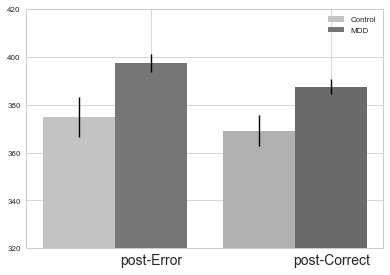

In [230]:
# Generate the 'classic' (averaged within subjects) Rab/Lam RT plot; looks the same as time 1

rl_grp_rt = rl_use.groupby(['group','rab_lam','ProjectSpecificID'])['rt'].mean()

ctrl_rl1_rt = []
ctrl_rl2_rt = []
mdd_rl1_rt = []
mdd_rl2_rt = []

for key in rl_grp_rt.keys():
    if key[0] == 'CTL' and key[1] == 1:
        ctrl_rl1_rt.append(rl_grp_rt[key])
    elif key[0] == 'CTL' and key[1] == 2:
        ctrl_rl2_rt.append(rl_grp_rt[key])
    elif key[0] == 'MDD' and key[1] == 1:
        mdd_rl1_rt.append(rl_grp_rt[key])
    elif key[0] == 'MDD' and key[1] == 2:
        mdd_rl2_rt.append(rl_grp_rt[key])

ctrl_rl1_rt_se = sp.stats.sem(ctrl_rl1_rt)
ctrl_rl2_rt_se = sp.stats.sem(ctrl_rl2_rt)
mdd_rl1_rt_se = sp.stats.sem(mdd_rl1_rt)
mdd_rl2_rt_se = sp.stats.sem(mdd_rl2_rt)

ctrl_rl_rt_means = [np.mean(ctrl_rl1_rt), np.mean(ctrl_rl2_rt)]
ctrl_rl_rt_se = [ctrl_rl1_rt_se,ctrl_rl2_rt_se]

mdd_rl_rt_means = [np.mean(mdd_rl1_rt), np.mean(mdd_rl2_rt)]
mdd_rl_rt_se = [mdd_rl1_rt_se,mdd_rl2_rt_se]

# Plot

index = [0.05,0.55]
index = np.asarray(index)
width = 0.2

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylim([320,420])
ax1.bar(index,ctrl_rl_rt_means,width,color=['#C3C3C3','#B0B0B0'],yerr=ctrl_rl_rt_se,ecolor='black',label='Control')
ax1.bar(index+width,mdd_rl_rt_means,width,color=['#767676','#6A6A6A'],yerr=mdd_rl_rt_se,ecolor='black',label='MDD')
ax1.set_xticks([0.25,0.75])
ax1.set_xticklabels(['post-Error','post-Correct'], fontsize=14)
ax1.legend()

In [231]:
# Here are the means averaged within-subjects
print ('Controls: post-error RT = ' + '{:.2f}'.format(ctrl_rl_rt_means[0]) + '; post-correct RT = ' + '{:.2f}'.format(ctrl_rl_rt_means[1]))
print ('MDD: post-error RT = ' + '{:.2f}'.format(mdd_rl_rt_means[0]) + '; post-correct RT = ' + '{:.2f}'.format(mdd_rl_rt_means[1]))

Controls: post-error RT = 374.81; post-correct RT = 369.14
MDD: post-error RT = 397.36; post-correct RT = 387.60


## DDM

Below is a very general model that only takes group into account. I need to sample more so that it's a little cleaner, I was just curious if parameters for the PRT look like they correlate w/ the flanker parameters for each person, and it seems like they definitely do!

In [232]:
all_data = hddm.load_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_DDM_Clin_s1_Mar-03-1058AM-2017.csv')
all_data['rt'] = all_data['rt'] / 1000 # convert to seconds
all_data = all_data[all_data.outlier == 0]

In [233]:
all_data.head()

,ProjectSpecificID,site,subject,session,group,block,trial,stimulus,response,accuracy,rt,feedback,ln_rt,outlier,rab_lam,gratton
0,CU0009,CU,9,1,CTL,1,1,INC,right,1.0,0.541,Blank,6.293419,0,0,0
1,CU0009,CU,9,1,CTL,1,2,CON,left,1.0,0.502,Blank,6.218600,0,2,0
2,CU0009,CU,9,1,CTL,1,3,INC,right,0.0,0.379,Blank,5.937536,0,0,1
3,CU0009,CU,9,1,CTL,1,4,CON,right,1.0,0.379,Blank,5.937536,0,1,0
4,CU0009,CU,9,1,CTL,1,5,INC,left,1.0,0.491,Blank,6.196444,0,0,1


In [234]:
# need to rename these columns for hddm
all_data = all_data.rename(index = str, columns = {'response': 'left_right_resp', 'accuracy': 'response', 'ProjectSpecificID': 'subj_idx'})
all_data = all_data[pd.notnull(all_data['response'])] # having some NaNs was giving us an error
all_data.head()

,subj_idx,site,subject,session,group,block,trial,stimulus,left_right_resp,response,rt,feedback,ln_rt,outlier,rab_lam,gratton
0,CU0009,CU,9,1,CTL,1,1,INC,right,1.0,0.541,Blank,6.293419,0,0,0
1,CU0009,CU,9,1,CTL,1,2,CON,left,1.0,0.502,Blank,6.218600,0,2,0
2,CU0009,CU,9,1,CTL,1,3,INC,right,0.0,0.379,Blank,5.937536,0,0,1
3,CU0009,CU,9,1,CTL,1,4,CON,right,1.0,0.379,Blank,5.937536,0,1,0
4,CU0009,CU,9,1,CTL,1,5,INC,left,1.0,0.491,Blank,6.196444,0,0,1


In [153]:
m_general = hddm.HDDM(all_data, depends_on={'v': 'group', 'a': 'group', 't':'group'})
m_general.find_starting_values() 
m_general.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 546.4 sec

P_v(MDD > CTL) =  0.163333333333
P_v(CTL > MDD) =  0.836666666667


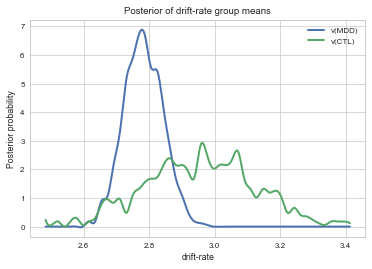

In [154]:
v_MDD, v_CTL = m_general.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CTL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

print ("P_v(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_v(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())

P_a(MDD > CTL) =  0.984444444444
P_a(CTL > MDD) =  0.0155555555556


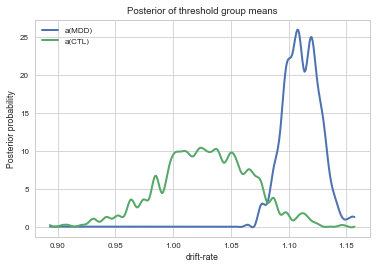

In [155]:
a_MDD, a_CTL = m_general.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CTL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())

P_t(MDD > CTL) =  0.0477777777778
P_t(CTL > MDD) =  0.952222222222


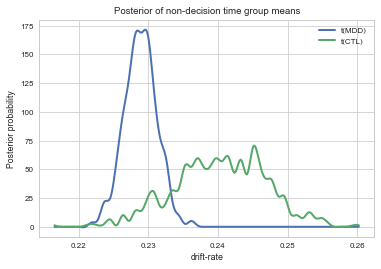

In [156]:
t_MDD, t_CTL = m_general.nodes_db.node[['t(MDD)','t(CTL)']]
hddm.analyze.plot_posterior_nodes([t_MDD, t_CTL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision time group means')

print ("P_t(MDD > CTL) = ", (t_MDD.trace() > t_CTL.trace()).mean())
print ("P_t(CTL > MDD) = ", (t_CTL.trace() > t_MDD.trace()).mean())

In [158]:
flanker = m_general.gen_stats()
flanker.to_csv('/Users/mlm2/Work/Expts/EMBARC/flanker_stats_general.csv')

In [162]:
prt_data = hddm.load_csv('/Users/mlm2/Work/Expts/EMBARC/Data/prt_trial_compact.csv')
prt_data['rt'] = prt_data['rt'] / 1000 # convert to seconds

In [164]:
prt_general = hddm.HDDM(prt_data, depends_on={'v': 'feasibility', 'a': 'feasibility', 't':'feasibility'})
prt_general.find_starting_values()
prt_general.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 356.7 sec

In [ ]:
prt = prt_general.gen_stats()
prt.to_csv('/Users/mlm2/Work/Expts/EMBARC/prt_stats_general.csv')

Here is where I start to look at correlations between the prt and flanker parameters...

In [112]:
# load in the prt ddm data with parameter estimates for each person
prt = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/prt_stats_general.csv')
prt.rename(columns={'Unnamed: 0': 'to_extract','mean': 'prt_mean'}, inplace=True)
prt.head()

,to_extract,prt_mean,std,2.5q,25q,50q,75q,97.5q,mc err
0,a(CTL),1.052970,0.031297,0.993909,1.031150,1.052641,1.072264,1.114349,0.001070
1,a(MDD),1.142476,0.012019,1.118268,1.134121,1.142938,1.150604,1.165649,0.000491
2,a_std,0.187468,0.008611,0.171414,0.181513,0.187128,0.193028,0.204938,0.000316
3,a_subj(CTL).CU0009,1.346859,0.050200,1.254514,1.311926,1.345075,1.380069,1.448540,0.002110
4,a_subj(CTL).CU0013,1.017140,0.036506,0.948142,0.990800,1.016336,1.043021,1.093019,0.001686


In [113]:
# load in the flanker ddm data with parameter estimates for each person
flanker = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/flanker_stats_general.csv')
flanker.rename(columns={'Unnamed: 0': 'to_extract', 'mean':'flk_mean'}, inplace=True)
flanker.head()

,to_extract,flk_mean,std,2.5q,25q,50q,75q,97.5q,mc err
0,a(CTL),1.027671,0.038038,0.949083,1.002326,1.028688,1.054342,1.102624,0.001255
1,a(MDD),1.109613,0.015026,1.080745,1.098861,1.109061,1.120056,1.138815,0.000503
2,a_std,0.251650,0.011577,0.230601,0.243749,0.250733,0.259447,0.276561,0.000569
3,a_subj(CTL).CU0009,0.969073,0.038487,0.898085,0.941929,0.967727,0.991931,1.052680,0.002160
4,a_subj(CTL).CU0013,0.968372,0.034430,0.903993,0.945111,0.967298,0.990172,1.039578,0.001874


In [114]:
def get_param(item):
    '''Returns the paramerter from the genstats() data'''
    if len(item) == 18:
        param = item[0]
    else:
        param = np.nan
    return(param)

In [115]:
def get_group(item):
    '''Returns the group info from the genstats() data'''
    if len(item) == 18:
        group = item[7:10]
    else:
        group = np.nan
    return(group)

In [116]:
def get_id(item):
    '''Returns the id info from the genstats() data'''
    if len(item) == 18:
        sub_id = item[12:18]
    else:
        sub_id = np.nan
    return(sub_id)

In [117]:
# adding in the PRT parameters and setting the columns
prt = prt[['to_extract', 'prt_mean']]
prt['param'] = prt.to_extract.apply(get_param)
prt['group'] = prt.to_extract.apply(get_group)
prt['ProjectSpecificID'] = prt.to_extract.apply(get_id)
prt.head(10)

,to_extract,prt_mean,param,group,ProjectSpecificID
0,a(CTL),1.052970,NaN,NaN,NaN
1,a(MDD),1.142476,NaN,NaN,NaN
2,a_std,0.187468,NaN,NaN,NaN
3,a_subj(CTL).CU0009,1.346859,a,CTL,CU0009
4,a_subj(CTL).CU0013,1.017140,a,CTL,CU0013
5,a_subj(CTL).CU0017,0.900801,a,CTL,CU0017
6,a_subj(CTL).CU0018,0.825681,a,CTL,CU0018
7,a_subj(CTL).CU0020,1.068162,a,CTL,CU0020
8,a_subj(CTL).CU0023,1.109272,a,CTL,CU0023
9,a_subj(CTL).CU0026,0.923671,a,CTL,CU0026


In [118]:
# adding in the flanker parameters and setting the columns
flanker = flanker[['to_extract', 'flk_mean']]
flanker['param'] = flanker.to_extract.apply(get_param)
flanker['group'] = flanker.to_extract.apply(get_group)
flanker['ProjectSpecificID'] = flanker.to_extract.apply(get_id)
flanker.head(10)

,to_extract,flk_mean,param,group,ProjectSpecificID
0,a(CTL),1.027671,NaN,NaN,NaN
1,a(MDD),1.109613,NaN,NaN,NaN
2,a_std,0.251650,NaN,NaN,NaN
3,a_subj(CTL).CU0009,0.969073,a,CTL,CU0009
4,a_subj(CTL).CU0013,0.968372,a,CTL,CU0013
5,a_subj(CTL).CU0017,0.613774,a,CTL,CU0017
6,a_subj(CTL).CU0019,1.114557,a,CTL,CU0019
7,a_subj(CTL).CU0020,0.892061,a,CTL,CU0020
8,a_subj(CTL).CU0023,1.120079,a,CTL,CU0023
9,a_subj(CTL).CU0026,1.181560,a,CTL,CU0026


In [119]:
# merging the prt and flanker parameter estimates for each participant
prt_flank_merged = pd.merge(flanker, prt, on=['ProjectSpecificID','param'])
prt_flank_merged = prt_flank_merged[pd.notnull(prt_flank_merged['ProjectSpecificID'])]
prt_flank_merged.rename(columns={'group_x': 'group'}, inplace=True)
del prt_flank_merged['group_y']
prt_flank_merged.head(10)

,to_extract_x,flk_mean,param,group,ProjectSpecificID,to_extract_y,prt_mean
81,a_subj(CTL).CU0009,0.969073,a,CTL,CU0009,a_subj(CTL).CU0009,1.346859
82,a_subj(CTL).CU0013,0.968372,a,CTL,CU0013,a_subj(CTL).CU0013,1.017140
83,a_subj(CTL).CU0017,0.613774,a,CTL,CU0017,a_subj(CTL).CU0017,0.900801
84,a_subj(CTL).CU0020,0.892061,a,CTL,CU0020,a_subj(CTL).CU0020,1.068162
85,a_subj(CTL).CU0023,1.120079,a,CTL,CU0023,a_subj(CTL).CU0023,1.109272
86,a_subj(CTL).CU0026,1.181560,a,CTL,CU0026,a_subj(CTL).CU0026,0.923671
87,a_subj(CTL).CU0028,1.044522,a,CTL,CU0028,a_subj(CTL).CU0028,1.010510
88,a_subj(CTL).CU0031,1.202118,a,CTL,CU0031,a_subj(CTL).CU0031,1.140736
89,a_subj(CTL).MG0006,1.074627,a,CTL,MG0006,a_subj(CTL).MG0006,0.989148
90,a_subj(CTL).MG0007,0.801220,a,CTL,MG0007,a_subj(CTL).MG0007,1.550600


In [120]:
# checking that we have each participant in three times (once for each param)
print(prt_flank_merged.ProjectSpecificID.count())
print(prt_flank_merged.ProjectSpecificID.nunique())

873
291


In [121]:
# how many participants do we have?
prt_flank_merged.groupby('group')['ProjectSpecificID'].nunique()

group
CTL     34
MDD    257
Name: ProjectSpecificID, dtype: int64


	Pearson's product-moment correlation

data:  drift_merged$flk_mean and drift_merged$prt_mean
t = 4.4997, df = 289, p-value = 9.872e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1451678 0.3602600
sample estimates:
     cor 
0.255878 



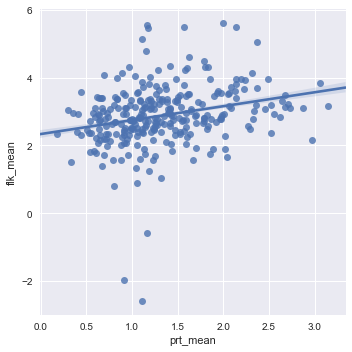

In [122]:
# drift rates significantly correlate

drift_merged = prt_flank_merged[prt_flank_merged['param'] == 'v']
corr_drift_rate = sns.lmplot(y='flk_mean', x = 'prt_mean', data=drift_merged,ci=68)

%Rpush drift_merged
%R corr_drift_rate <- cor.test(drift_merged$flk_mean,drift_merged$prt_mean,method="pearson")
%R print (corr_drift_rate)


	Pearson's product-moment correlation

data:  threshold_merged$flk_mean and threshold_merged$prt_mean
t = 6.6852, df = 289, p-value = 1.188e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2620090 0.4615258
sample estimates:
      cor 
0.3659652 



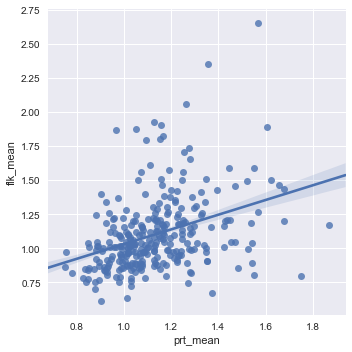

In [123]:
# thresholds significantly correlate

threshold_merged = prt_flank_merged[prt_flank_merged['param'] == 'a']
corr_drift_rate = sns.lmplot(y='flk_mean', x = 'prt_mean', data=threshold_merged,ci=68)

%Rpush threshold_merged
%R corr_threshold <- cor.test(threshold_merged$flk_mean,threshold_merged$prt_mean,method="pearson")
%R print (corr_threshold)


	Pearson's product-moment correlation

data:  nondecision_merged$flk_mean and nondecision_merged$prt_mean
t = 9.2681, df = 289, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3848669 0.5626787
sample estimates:
     cor 
0.478666 



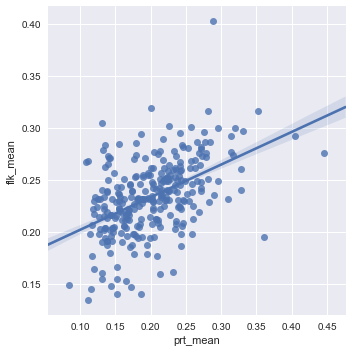

In [124]:
# non-decision times significantly correlate

nondecision_merged = prt_flank_merged[prt_flank_merged['param'] == 't']
corr_nondecision = sns.lmplot(y='flk_mean', x = 'prt_mean', data=nondecision_merged,ci=68)

%Rpush nondecision_merged
%R corr_nondecision <- cor.test(nondecision_merged$flk_mean,nondecision_merged$prt_mean,method="pearson")
%R print (corr_nondecision)

In [125]:
# save the merged df
prt_flank_merged.to_csv('/Users/mlm2/Work/Expts/EMBARC/flanker_prt_merged.csv')

In [260]:
# a within subjects model for just the CTLs
ctl_ddm = all_data[all_data.group == 'CTL']
ctl_within_m = hddm.HDDMRegressor(ctl_ddm, ['v ~ 0 + C(stimulus)', 'a ~ 0 + C(stimulus)'])
ctl_within_m.sample(1000, burn=100)

Adding these covariates:
['v_C(stimulus)[CON]', 'v_C(stimulus)[INC]']
Adding these covariates:
['a_C(stimulus)[CON]', 'a_C(stimulus)[INC]']
 [-----------------100%-----------------] 1001 of 1000 complete in 2036.3 sec

In [250]:
# a within subjects model for just the MDDs; takes a full day
mdd_ddm = all_data[all_data.group == 'MDD']
mdd_within_m = hddm.HDDMRegressor(mdd_ddm, ['v ~ 0 + C(stimulus)', 'a ~ 0 + C(stimulus)'])
mdd_within_m.sample(1000, burn=100)

Adding these covariates:
['v_C(stimulus)[CON]', 'v_C(stimulus)[INC]']
Adding these covariates:
['a_C(stimulus)[CON]', 'a_C(stimulus)[INC]']
 [-----------------100%-----------------] 1001 of 1000 complete in 65608.6 sec

In [252]:
mdd_within_m.get_group_nodes()

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,subj_idx,site,...,rab_lam,gratton,mean,std,2.5q,25q,50q,75q,97.5q,mc err
t,t,True,False,False,t,(),[],False,NaN,NaN,...,NaN,NaN,0.223344,0.00241791,0.218702,0.221839,0.223336,0.224804,0.228246,7.75523e-05
t_std,t_std,True,False,False,t_std,(),[],False,NaN,NaN,...,NaN,NaN,0.0408112,0.0018325,0.0376085,0.0394835,0.0406952,0.0420738,0.0444761,6.5337e-05
v_C(stimulus)[CON],v_C(stimulus)[CON],True,False,False,v_C(stimulus)[CON],(),[],False,NaN,NaN,...,NaN,NaN,5.15113,0.108783,4.93361,5.07737,5.14607,5.22267,5.36144,0.00400595
v_C(stimulus)[CON]_std,v_C(stimulus)[CON]_std,True,False,False,v_C(stimulus)[CON]_std,(),[],False,NaN,NaN,...,NaN,NaN,1.81828,0.0794644,1.67594,1.76416,1.81408,1.87297,1.98059,0.00303447
v_C(stimulus)[INC],v_C(stimulus)[INC],True,False,False,v_C(stimulus)[INC],(),[],False,NaN,NaN,...,NaN,NaN,1.50795,0.081135,1.35473,1.45307,1.50583,1.56156,1.66961,0.00291101
v_C(stimulus)[INC]_std,v_C(stimulus)[INC]_std,True,False,False,v_C(stimulus)[INC]_std,(),[],False,NaN,NaN,...,NaN,NaN,1.34781,0.0615114,1.23127,1.30552,1.3443,1.3892,1.46921,0.00274057
a_C(stimulus)[CON],a_C(stimulus)[CON],True,False,False,a_C(stimulus)[CON],(),[],False,NaN,NaN,...,NaN,NaN,1.53431,0.022209,1.49325,1.5182,1.53352,1.54846,1.57975,0.00100273
a_C(stimulus)[CON]_std,a_C(stimulus)[CON]_std,True,False,False,a_C(stimulus)[CON]_std,(),[],False,NaN,NaN,...,NaN,NaN,0.353619,0.0176321,0.318915,0.34132,0.354086,0.36481,0.391254,0.00086101
a_C(stimulus)[INC],a_C(stimulus)[INC],True,False,False,a_C(stimulus)[INC],(),[],False,NaN,NaN,...,NaN,NaN,1.16415,0.0200109,1.12454,1.15066,1.16322,1.17742,1.20396,0.000735413
a_C(stimulus)[INC]_std,a_C(stimulus)[INC]_std,True,False,False,a_C(stimulus)[INC]_std,(),[],False,NaN,NaN,...,NaN,NaN,0.346437,0.0168997,0.315016,0.334906,0.346469,0.357651,0.381326,0.000856731


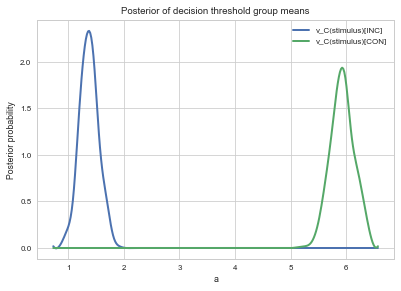

In [261]:
# lets look at drift rate differences in the stim type for CONTROLS
inc_CTL, con_CTL = ctl_within_m.nodes_db.node[['v_C(stimulus)[INC]','v_C(stimulus)[CON]']]
hddm.analyze.plot_posterior_nodes([inc_CTL, con_CTL])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision threshold group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

#print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
#print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())

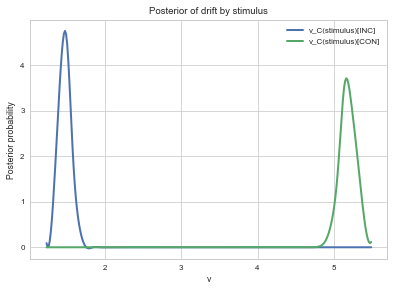

In [256]:
# does drift rate look similar in MDDs?
inc_MDD, con_MDD = mdd_within_m.nodes_db.node[['v_C(stimulus)[INC]','v_C(stimulus)[CON]']]
hddm.analyze.plot_posterior_nodes([inc_MDD, con_MDD])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift by stimulus')
plt.savefig('ctl_mdd_a_more_samples.pdf')

#print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
#print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())

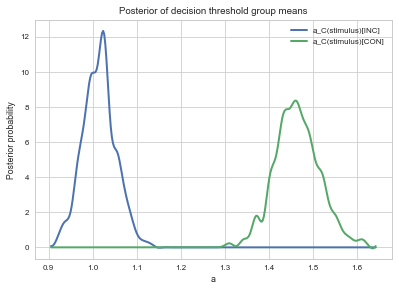

In [263]:
# lets look at threshold differences in the stim type for CONTROLS
inc_CTL, con_CTL = ctl_within_m.nodes_db.node[['a_C(stimulus)[INC]','a_C(stimulus)[CON]']]
hddm.analyze.plot_posterior_nodes([inc_CTL, con_CTL])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision threshold group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

#print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
#print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())

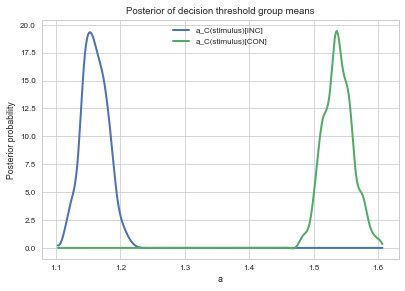

In [258]:
# does threshold look similar in MDDs?
inc_MDD, con_MDD = mdd_within_m.nodes_db.node[['a_C(stimulus)[INC]','a_C(stimulus)[CON]']]
hddm.analyze.plot_posterior_nodes([inc_MDD, con_MDD])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision threshold group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

#print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
#print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())

**Can ignore below for now, just playing around. **

In [136]:
# any correlations with clinical measures?

prt_flank_clin = pd.merge(prt_flank_merged,clin_data,on='ProjectSpecificID')
prt_flank_clin.head()

,to_extract_x,flk_mean,param,group,ProjectSpecificID,to_extract_y,prt_mean,feasibility,shaps_total_dichotomous,shaps_total_continuous,severity1,partic_age,partic_gender,masq2_29,hamd_09,hamd_score_24,masq2_score_gd,masq2_score_ad,masq2_score_aa,neo2_score_ne
0,a_subj(CTL).CU0009,0.969073,a,CTL,CU0009,a_subj(CTL).CU0009,1.346859,4.0,0.0,16.0,2.0,41.0,Female,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,v_subj(CTL).CU0009,3.081353,v,CTL,CU0009,v_subj(CTL).CU0009,1.197439,4.0,0.0,16.0,2.0,41.0,Female,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,t_subj(CTL).CU0009,0.269761,t,CTL,CU0009,t_subj(CTL).CU0009,0.176728,4.0,0.0,16.0,2.0,41.0,Female,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,a_subj(CTL).CU0013,0.968372,a,CTL,CU0013,a_subj(CTL).CU0013,1.017140,4.0,0.0,20.0,2.0,36.0,Male,2.0,0.0,3.0,11.0,26.0,11.0,13.0
4,v_subj(CTL).CU0013,2.921769,v,CTL,CU0013,v_subj(CTL).CU0013,1.099607,4.0,0.0,20.0,2.0,36.0,Male,2.0,0.0,3.0,11.0,26.0,11.0,13.0



	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$neo2_score_ne
t = -0.3484, df = 286, p-value = 0.7278
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.13585288  0.09520921
sample estimates:
        cor 
-0.02059687 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$neo2_score_ne
t = 1.5064, df = 286, p-value = 0.1331
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.02713499  0.20222836
sample estimates:
       cor 
0.08872269 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$neo2_score_ne
t = -1.8584, df = 286, p-value = 0.06414
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.222007769  0.006429425
sample estimates:
       cor 
-0.1092312 



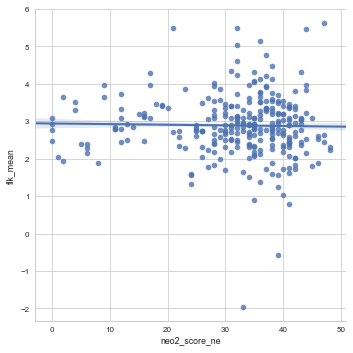

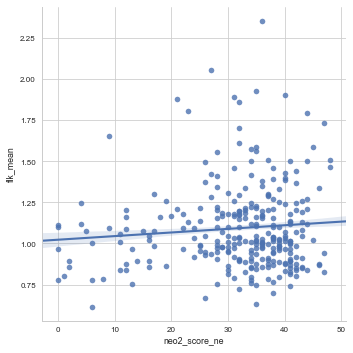

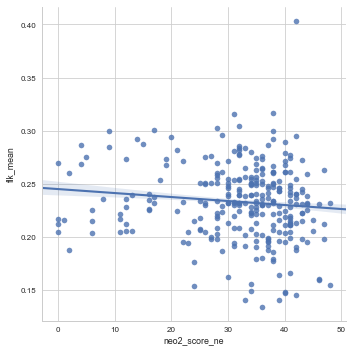

In [274]:
# anything with the neo ne?
# NO

params = ['v','a','t']
for param in params:
    prt_flank_clin_param = prt_flank_clin[prt_flank_clin['param'] == param]
    corr_param = sns.lmplot(y='flk_mean', x = 'neo2_score_ne', data=prt_flank_clin_param,ci=68)

    %Rpush prt_flank_clin_param
    %R corr_param <- cor.test(prt_flank_clin_param$flk_mean,prt_flank_clin_param$neo2_score_ne,method="pearson")
    %R print (corr_param)
    
    

In [130]:
list(prt_flank_clin_param)

['to_extract_x',
 'flk_mean',
 'param',
 'group',
 'ProjectSpecificID',
 'to_extract_y',
 'prt_mean',
 'feasibility',
 'shaps_total_dichotomous',
 'shaps_total_continuous',
 'severity1',
 'partic_age',
 'partic_gender',
 'masq2_29',
 'hamd_09',
 'hamd_score_24',
 'masq2_score_gd',
 'masq2_score_ad',
 'masq2_score_aa',
 'neo2_score_ne']


	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$shaps_total_continuous
t = 0.10872, df = 288, p-value = 0.9135
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1088535  0.1214963
sample estimates:
        cor 
0.006406384 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$shaps_total_continuous
t = 2.963, df = 288, p-value = 0.003301
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.05796477 0.28159708
sample estimates:
      cor 
0.1719961 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$shaps_total_continuous
t = -1.2119, df = 288, p-value = 0.2265
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.18489575  0.04430997
sample estimates:
        cor 
-0.07123316 



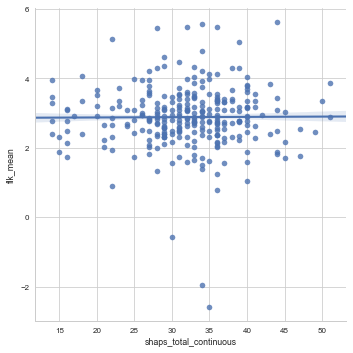

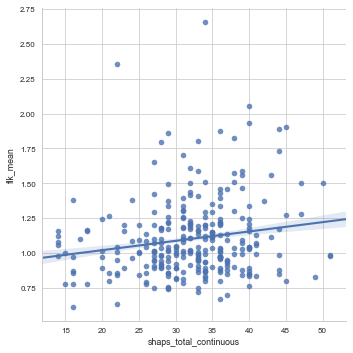

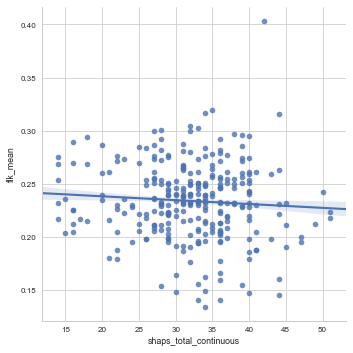

In [273]:
# anything with the shaps in the flanker?
# positive correlation with flanker threshold and shaps

params = ['v','a','t']
for param in params:
    prt_flank_clin_param = prt_flank_clin[prt_flank_clin['param'] == param]
    corr_param = sns.lmplot(y='flk_mean', x = 'shaps_total_continuous', data=prt_flank_clin_param,ci=68)

    %Rpush prt_flank_clin_param
    %R corr_param <- cor.test(prt_flank_clin_param$flk_mean,prt_flank_clin_param$shaps_total_continuous,method="pearson")
    %R print (corr_param)
    
    


	Pearson's product-moment correlation

data:  prt_flank_clin_param$prt_mean and prt_flank_clin_param$shaps_total_continuous
t = -0.91798, df = 288, p-value = 0.3594
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.16814702  0.06154897
sample estimates:
        cor 
-0.05401352 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$prt_mean and prt_flank_clin_param$shaps_total_continuous
t = 1.1095, df = 288, p-value = 0.2681
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.05031649  0.17907513
sample estimates:
       cor 
0.06524119 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$prt_mean and prt_flank_clin_param$shaps_total_continuous
t = 0.30425, df = 288, p-value = 0.7612
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.09745576  0.13283037
sample estimates:
       cor 
0.01792503 



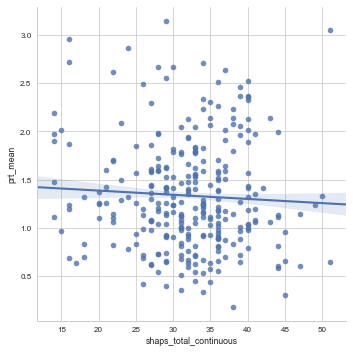

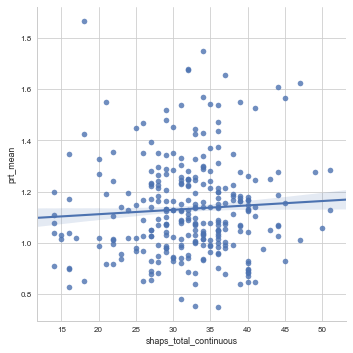

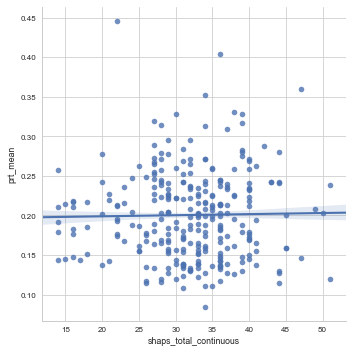

In [266]:
# anything with the shaps in the prt?
# nope

params = ['v','a','t']
for param in params:
    prt_flank_clin_param = prt_flank_clin[prt_flank_clin['param'] == param]
    corr_param = sns.lmplot(y='prt_mean', x = 'shaps_total_continuous', data=prt_flank_clin_param,ci=68)

    %Rpush prt_flank_clin_param
    %R corr_param <- cor.test(prt_flank_clin_param$prt_mean,prt_flank_clin_param$shaps_total_continuous,method="pearson")
    %R print (corr_param)
    
    


	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$hamd_score_24
t = -0.70707, df = 285, p-value = 0.4801
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.15686768  0.07429407
sample estimates:
       cor 
-0.0418468 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$hamd_score_24
t = 2.3273, df = 285, p-value = 0.02065
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02112127 0.24842108
sample estimates:
      cor 
0.1365682 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$hamd_score_24
t = -0.85524, df = 285, p-value = 0.3931
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.16540734  0.06556963
sample estimates:
        cor 
-0.05059538 



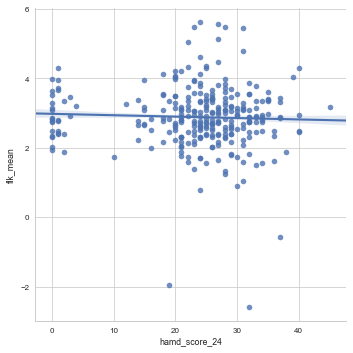

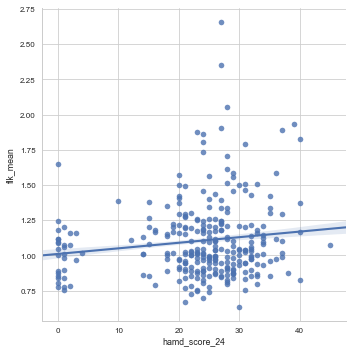

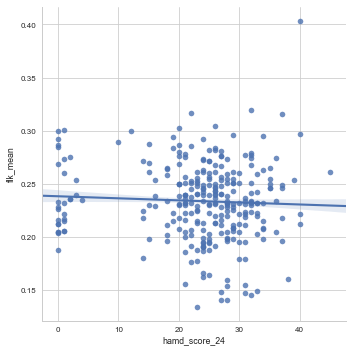

In [272]:
# anything with the hamd and flanker?
# Yes, correlation with threshold
params = ['v','a','t']
for param in params:
    prt_flank_clin_param = prt_flank_clin[prt_flank_clin['param'] == param]
    corr_param = sns.lmplot(y='flk_mean', x = 'hamd_score_24', data=prt_flank_clin_param,ci=68)

    %Rpush prt_flank_clin_param
    %R corr_param <- cor.test(prt_flank_clin_param$flk_mean,prt_flank_clin_param$hamd_score_24,method="pearson")
    %R print (corr_param)
    
    


	Pearson's product-moment correlation

data:  prt_flank_clin_param$prt_mean and prt_flank_clin_param$hamd_score_24
t = -2.4245, df = 285, p-value = 0.01595
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.25376120 -0.02681745
sample estimates:
      cor 
-0.142157 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$prt_mean and prt_flank_clin_param$hamd_score_24
t = 2.6461, df = 285, p-value = 0.008594
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.03978518 0.26586696
sample estimates:
      cor 
0.1548528 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$prt_mean and prt_flank_clin_param$hamd_score_24
t = -0.54965, df = 285, p-value = 0.583
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.14776564  0.08355425
sample estimates:
        cor 
-0.03254147 



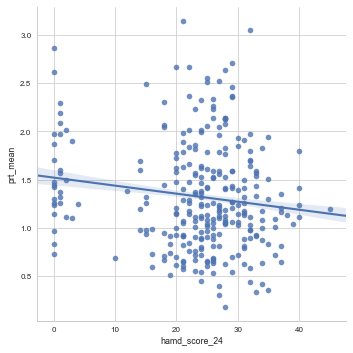

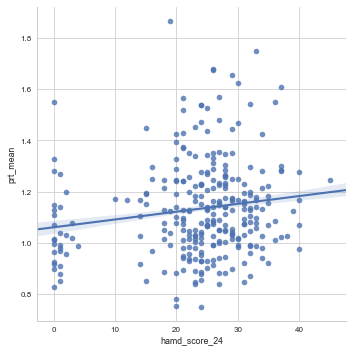

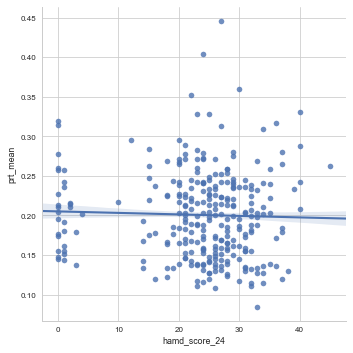

In [267]:
# anything with the hamd and prt?
# Yes, correlation with threshold & drift rate
params = ['v','a','t']
for param in params:
    prt_flank_clin_param = prt_flank_clin[prt_flank_clin['param'] == param]
    corr_param = sns.lmplot(y='prt_mean', x = 'hamd_score_24', data=prt_flank_clin_param,ci=68)

    %Rpush prt_flank_clin_param
    %R corr_param <- cor.test(prt_flank_clin_param$prt_mean,prt_flank_clin_param$hamd_score_24,method="pearson")
    %R print (corr_param)
    
    


	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$shaps_total_continuous
t = 0.10872, df = 288, p-value = 0.9135
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1088535  0.1214963
sample estimates:
        cor 
0.006406384 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$shaps_total_continuous
t = 2.963, df = 288, p-value = 0.003301
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.05796477 0.28159708
sample estimates:
      cor 
0.1719961 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$shaps_total_continuous
t = -1.2119, df = 288, p-value = 0.2265
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.18489575  0.04430997
sample estimates:
        cor 
-0.07123316 



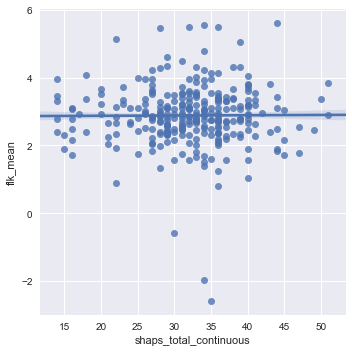

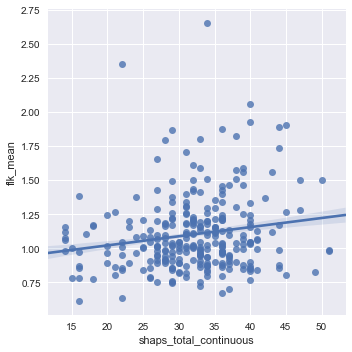

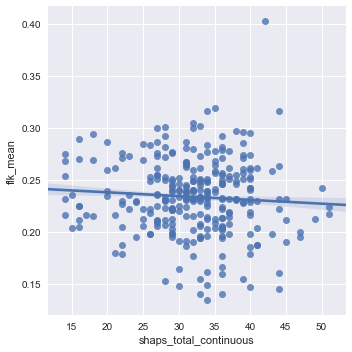

In [131]:
# anything with the shaps in the flanker?
# positive correlation with flanker threshold and shaps

params = ['v','a','t']
for param in params:
    prt_flank_clin_param = prt_flank_clin[prt_flank_clin['param'] == param]
    corr_param = sns.lmplot(y='flk_mean', x = 'shaps_total_continuous', data=prt_flank_clin_param,ci=68)

    %Rpush prt_flank_clin_param
    %R corr_param <- cor.test(prt_flank_clin_param$flk_mean,prt_flank_clin_param$shaps_total_continuous,method="pearson")
    %R print (corr_param)
    
    


	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$masq2_score_ad
t = 0.59544, df = 286, p-value = 0.552
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.08072062  0.15015584
sample estimates:
       cor 
0.03518709 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$masq2_score_ad
t = 2.4006, df = 286, p-value = 0.017
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02537716 0.25202979
sample estimates:
      cor 
0.1405444 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$masq2_score_ad
t = 0.23845, df = 286, p-value = 0.8117
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1016469  0.1294666
sample estimates:
       cor 
0.01409817 



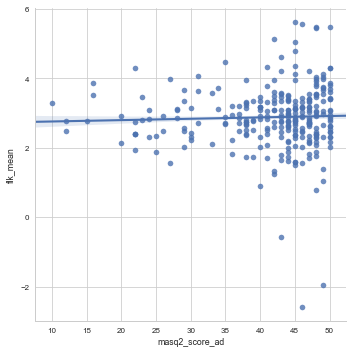

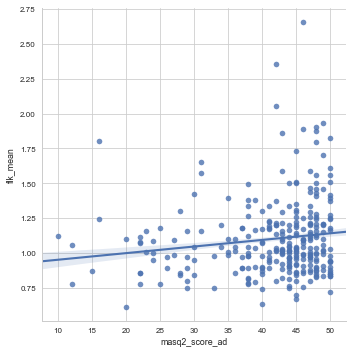

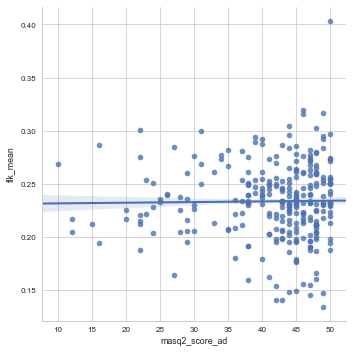

In [268]:
# anything with the masq anhedonia subscale for flanker?
# yes, threshold

params = ['v','a','t']
for param in params:
    prt_flank_clin_param = prt_flank_clin[prt_flank_clin['param'] == param]
    corr_param = sns.lmplot(y='flk_mean', x = 'masq2_score_ad', data=prt_flank_clin_param,ci=68)

    %Rpush prt_flank_clin_param
    %R corr_param <- cor.test(prt_flank_clin_param$flk_mean,prt_flank_clin_param$masq2_score_ad,method="pearson")
    %R print (corr_param)
    
    


	Pearson's product-moment correlation

data:  prt_flank_clin_param$prt_mean and prt_flank_clin_param$masq2_score_ad
t = -1.1132, df = 286, p-value = 0.2665
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.17989767  0.05027713
sample estimates:
        cor 
-0.06568398 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$prt_mean and prt_flank_clin_param$masq2_score_ad
t = 1.3936, df = 286, p-value = 0.1645
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.0337749  0.1958456
sample estimates:
       cor 
0.08212512 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$prt_mean and prt_flank_clin_param$masq2_score_ad
t = 0.052723, df = 286, p-value = 0.958
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1125024  0.1186542
sample estimates:
        cor 
0.003117539 



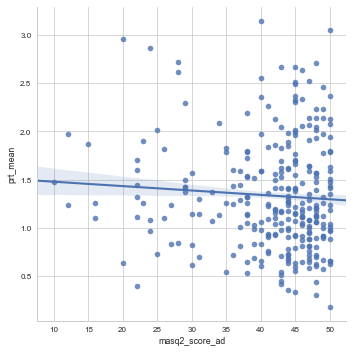

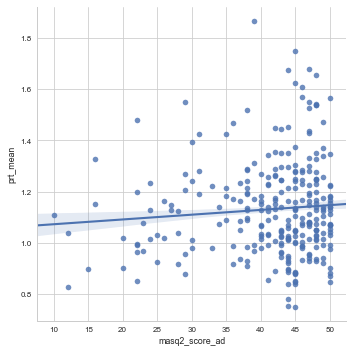

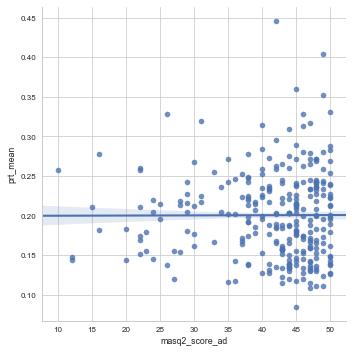

In [269]:
# anything with the masq anhedonia subscale for flanker?
# no

params = ['v','a','t']
for param in params:
    prt_flank_clin_param = prt_flank_clin[prt_flank_clin['param'] == param]
    corr_param = sns.lmplot(y='prt_mean', x = 'masq2_score_ad', data=prt_flank_clin_param,ci=68)

    %Rpush prt_flank_clin_param
    %R corr_param <- cor.test(prt_flank_clin_param$prt_mean,prt_flank_clin_param$masq2_score_ad,method="pearson")
    %R print (corr_param)
    
    


	Pearson's product-moment correlation

data:  prt_flank_clin_param$prt_mean and prt_flank_clin_param$partic_age
t = -3.8885, df = 289, p-value = 0.0001252
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3295094 -0.1108366
sample estimates:
       cor 
-0.2229762 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$prt_mean and prt_flank_clin_param$partic_age
t = 5.5705, df = 289, p-value = 5.813e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2036987 0.4116301
sample estimates:
      cor 
0.3113867 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$prt_mean and prt_flank_clin_param$partic_age
t = 5.766, df = 289, p-value = 2.083e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2141287 0.4206475
sample estimates:
      cor 
0.3212017 



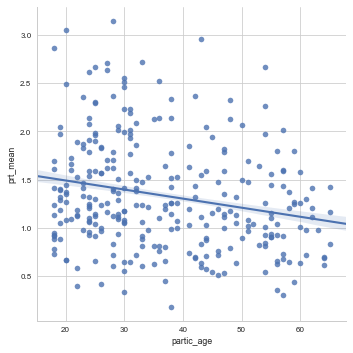

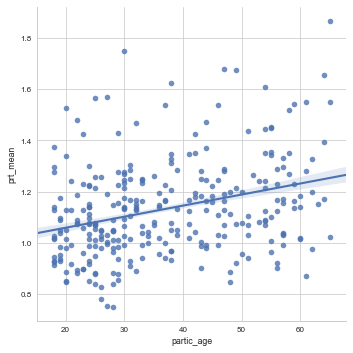

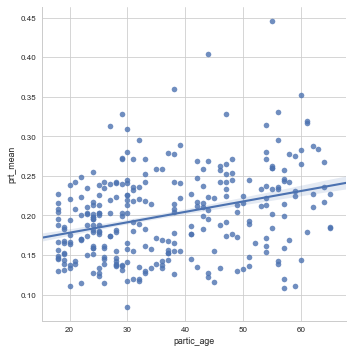

In [270]:
# age seems to be an important factor, is there a way we should be including this in the model??

params = ['v','a','t']
for param in params:
    prt_flank_clin_param = prt_flank_clin[prt_flank_clin['param'] == param]
    corr_param = sns.lmplot(y='prt_mean', x = 'partic_age', data=prt_flank_clin_param,ci=68)

    %Rpush prt_flank_clin_param
    %R corr_param <- cor.test(prt_flank_clin_param$prt_mean,prt_flank_clin_param$partic_age,method="pearson")
    %R print (corr_param)
    
    


	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$partic_age
t = -0.9974, df = 289, p-value = 0.3194
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.17239005  0.05679391
sample estimates:
        cor 
-0.05856978 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$partic_age
t = 5.2246, df = 289, p-value = 3.347e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1850368 0.3953936
sample estimates:
      cor 
0.2937679 




	Pearson's product-moment correlation

data:  prt_flank_clin_param$flk_mean and prt_flank_clin_param$partic_age
t = 7.7406, df = 289, p-value = 1.671e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3143950 0.5053007
sample estimates:
     cor 
0.414396 



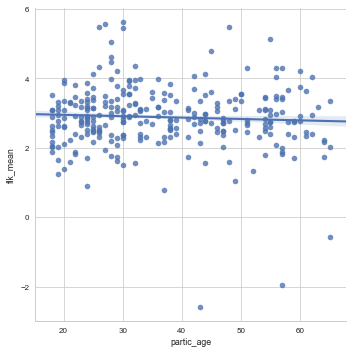

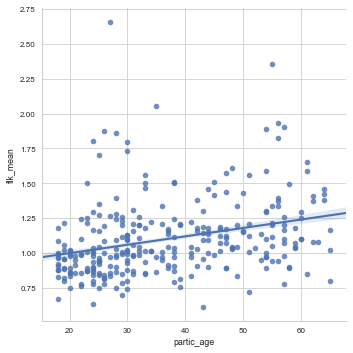

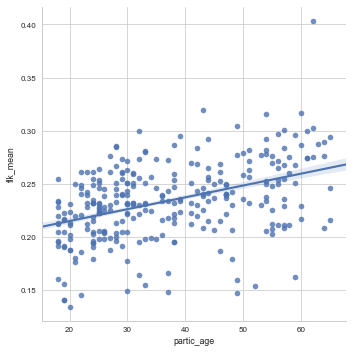

In [271]:
# similar effect of age in the prt, but it doesn't effect drift rate. 

params = ['v','a','t']
for param in params:
    prt_flank_clin_param = prt_flank_clin[prt_flank_clin['param'] == param]
    corr_param = sns.lmplot(y='flk_mean', x = 'partic_age', data=prt_flank_clin_param,ci=68)

    %Rpush prt_flank_clin_param
    %R corr_param <- cor.test(prt_flank_clin_param$flk_mean,prt_flank_clin_param$partic_age,method="pearson")
    %R print (corr_param)
    
    